In [1]:
import os
import random
import numpy as np
import pandas as pd
import pickle
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier, CatBoostRegressor
import optuna
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from scipy.optimize import minimize

from library.Data_Preprocessing import Balance_Ratio, training_def
from library.Imbalance_Sampling import label_divide, resampling_dataset
from library.Aging_Score_Contour import score1
from library.AdaBoost import train_set, multiple_set, multiple_month, line_chart, cf_matrix, AUC, PR_curve, \
     multiple_curve, PR_matrix, best_threshold, all_optuna, optuna_history 

os.chdir('C:/Users/user/Desktop/Darui_R08621110') 
os.getcwd()

'C:\\Users\\user\\Desktop\\Darui_R08621110'

## 

### CatBoost

In [6]:
# classifier
def CatBoostC(train_x, test_x, train_y, test_y, config, return_prob = False):
    
    clf = CatBoostClassifier(**config, verbose = 0)
    clf.fit(train_x, train_y)
    predict_y = clf.predict(test_x)
    define_predict = (predict_y > 0.5).astype(int)
    if return_prob:
        result = pd.DataFrame({'truth': test_y, 'predict': predict_y})
    else:
        result = pd.DataFrame({'truth': test_y, 'predict': define_predict})
    
    return result


# regressor
def CatBoostR(train_x, test_x, train_y, test_y, config):
    
    reg = CatBoostRegressor(**config, verbose = 0)
    reg.fit(train_x, train_y)
    predict_y = reg.predict(test_x)
    result = pd.DataFrame({'truth': test_y, 'predict': predict_y})

    return result


# classifier for all resampling datasets
def runall_CatBoostC(trainset_x, test_x, trainset_y, test_y, config):
    
    table_set = pd.DataFrame()
    bad_set = pd.DataFrame()
    set_index = list(config.keys())
    judge = set_index[0]

    for i, j in tqdm(enumerate(set_index)):
        print('\n', f'Data{j}:')
        if isinstance(config[judge], dict) :
            best_config = config[j]
        else :
            best_config = config
        
        result = CatBoostC(trainset_x[j], test_x, trainset_y[j], test_y, best_config)
        table = cf_matrix(result, trainset_y[j])
        table_set = pd.concat([table_set, table]).rename(index = {0: f'data{j}'})

    return table_set


# regressor for all resampling datasets
def runall_CatBoostR(num_set, trainset_x, test_x, trainset_y, test_y, config, thres_target = 'Recall', threshold = 0.8):
    
    table_set = pd.DataFrame()
    bad_set = pd.DataFrame()
    pr_dict = {}
    judge = list(config.keys())[0]

    for i in range(num_set):
        print('\n', f'Dataset {i}:')
        
        if isinstance(config[judge], dict) :
            best_config = config[f'set{i}']
        else :
            best_config = config

        predict = CatBoostR(trainset_x[f'set{i}'], test_x, trainset_y[f'set{i}'], test_y, best_config)
        pr_matrix = PR_matrix(predict, trainset_y[f'set{i}'])
        pr_dict[f'set{i}'] = pr_matrix
        
        best_data, best_thres = best_threshold(pr_matrix, target = thres_target, threshold = threshold)
        table_set = pd.concat([table_set, best_data]).rename(index = {best_data.index.values[0]: f'dataset {i}'})

    return pr_dict, table_set

### Probability Calibration (optional)

In [ ]:
def beta_map(s, a, b, c):
    return 1 / (1 + 1 / (np.power(np.exp(1), c)*(np.power(s, a) / np.power(1-s, b))))
                

def self_loss(three, test_y, predict_y):
    a, b, c = three
    new_s = beta_map(predict_y, a, b, c)
    loss = np.mean(test_y*np.log(new_s) + (1 - test_y)*np.log(1 - new_s))*(-1)
    return loss


def stratified_data(train_data, cv):
    
    good = train_data[train_data.GB == 0]
    bad = train_data[train_data.GB == 1]
    good_index = random.sample(good.index.to_list(), k = len(good))
    bad_index = random.sample(bad.index.to_list(), k = len(bad))
    
    train_x_dict = {}
    train_y_dict = {}
    valid_x_dict = {}
    valid_y_dict = {}
    for i in range(cv):
        
        if (i+1) == cv:
            good_valid_index = good_index[int(np.floor((i/cv)*len(good))): ]
            bad_valid_index = bad_index[int(np.floor((i/cv)*len(bad))): ]
        else:
            good_valid_index = good_index[int(np.floor((i/cv)*len(good))) : int(np.floor(((i+1)/cv)*len(good)))]
            bad_valid_index = bad_index[int(np.floor((i/cv)*len(bad))) : int(np.floor(((i+1)/cv)*len(bad)))]
        good_train_index = [x for x in good_index if x not in good_valid_index]
        bad_train_index = [x for x in bad_index if x not in bad_valid_index]
        
        good_train = good.loc[good_train_index]
        good_valid = good.loc[good_valid_index]
        bad_train = bad.loc[bad_train_index]
        bad_valid = bad.loc[bad_valid_index]
        train = pd.concat([good_train, bad_train], axis = 0)
        valid = pd.concat([good_valid, bad_valid], axis = 0)
        train_x_dict[i], train_y_dict[i], valid_x_dict[i], valid_y_dict[i] = label_divide(train, valid, train_only = False)

    return train_x_dict, train_y_dict, valid_x_dict, valid_y_dict


def cali_CatBoostC(train_x, train_y, test_x, test_y, config, method):
    
    clf = CatBoostClassifier(**config, silent = True)
    cali_clf = CalibratedClassifierCV(clf, method = method, cv = 5)
    cali_clf.fit(train_x, train_y)
    predict_y = cali_clf.predict_proba(test_x)[:, 1]
    predict = (predict_y > 0.5).astype(int)
    result = pd.DataFrame({'truth': test_y, 'predict': predict})
    
    return result 


def beta_CatBoostC(train_x, train_y, test_x, test_y, config, loss_function = self_loss):
    
    train = pd.concat([train_x, train_y], axis = 1)
    train_x_dict, train_y_dict, valid_x_dict, valid_y_dict = stratified_data(train, cv = 5)
    
    cali_param = {}
    for i in range(len(train_x_dict)):
        clf = CatBoostClassifier(**config, silent = True)
        clf.fit(train_x_dict[i], train_y_dict[i])
        predict_y = clf.predict_proba(valid_x_dict[i])[:, 1]
        mini_result = minimize(loss_function, [0.5, 0.5, 0.5], (valid_y_dict[i], predict_y))
        cali_param[i] = mini_result.x
        
    clf = CatBoostClassifier(**config, silent = True)
    clf.fit(train_x, train_y)
    predict_y = clf.predict_proba(test_x)[:, 1]
    
    cali_predict = np.array(0).astype(float)
    for i in range(len(cali_param)):
        cali_result = beta_map(predict_y, *cali_param[i])
        cali_predict = cali_predict + cali_result
    cali_predict /= len(cali_param)
      
    predict = (cali_predict > 0.5).astype(int)
    result = pd.DataFrame({'truth': test_y, 'predict': predict})

    return result


def all_cali_CatBoostC(trainset_x, trainset_y, test_x, test_y, config_dict, method):
    
    keys = config_dict.keys()
    all_result = pd.DataFrame()
    for i in keys:
        print('\n', f'Data{i}:')
        
        if method in ['isotonic', 'sigmoid']:
            table = cali_CatBoostC(trainset_x[i], trainset_y[i], test_x, test_y, config_dict[i], method)
        elif method == 'beta':
            table = beta_CatBoostC(trainset_x[i], trainset_y[i], test_x, test_y, config_dict[i])
        result_df = cf_matrix(table, trainset_y[i])
        all_result = pd.concat([all_result, result_df], axis = 0).rename(index = {0: f'data{i}'})
        
    return all_result

### Optuna

In [3]:
# creator of optuna study for CatBoost
def CatBoost_creator(train_data, mode, num_valid = 5, label = 'GB') :

    def objective(trial) :
    
        param_1 = {
            'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
            'iterations': trial.suggest_categorical('iterations', [100, 300, 500]),
            'depth': trial.suggest_int('depth', 2, 12, step = 2),
            'learning_rate': trial.suggest_float('learning_rate', 0.025, 0.325, step = 0.05),
            'subsample': trial.suggest_float('subsample', 0.3, 0.9, step = 0.2),
            'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10) 
        }

        if param_1['grow_policy'] == 'Depthwise' :
            param_2 = {
                'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 60, step = 5)
            }
            param = {**param_1, **param_2}
        
        elif param_1['grow_policy'] == 'Lossguide' :
            param_3 = {
                'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 60, step = 5),
                'max_leaves': trial.suggest_int('max_leaves', 10, 50, step = 5)
            }
            param = {**param_1, **param_3}
        
        else :
            param = param_1

        result_list = []
        for i in range(num_valid):

            train_good = train_data[train_data.GB == 0]
            train_bad = train_data[train_data.GB == 1]
            train_good_x, train_good_y = label_divide(train_good, None, label, train_only = True)
            train_bad_x, train_bad_y = label_divide(train_bad, None, label, train_only = True)
            train_g_x, valid_g_x, train_g_y, valid_g_y = train_test_split(train_good_x, train_good_y, test_size = 0.25)
            train_b_x, valid_b_x, train_b_y, valid_b_y = train_test_split(train_bad_x, train_bad_y, test_size = 0.25)
            train_x = pd.concat([train_g_x, train_b_x], axis = 0)
            train_y = pd.concat([train_g_y, train_b_y], axis = 0)
            valid_x = pd.concat([valid_g_x, valid_b_x], axis = 0)
            valid_y = pd.concat([valid_g_y, valid_b_y], axis = 0)

            if mode == 'C':
                result = CatBoostC(train_x, valid_x, train_y, valid_y, param)
                table = cf_matrix(result, valid_y)
                recall = table['Recall']
                precision = table['Precision']
                beta = 1
                if recall.values > 0:
                    fscore = ((1+beta**2)*recall*precision) / (recall+(beta**2)*precision) 
                else:
                    fscore = 0
                result_list.append(fscore)

            elif mode == 'R':
                result = CatBoostR(train_x, valid_x, train_y, valid_y, param)
                pr_matrix = PR_matrix(result, valid_y)
                auc = AUC(pr_matrix['Recall'], pr_matrix['Aging Rate'])
                result_list.append((-1)*auc)

        return np.mean(result_list)

    return objective

### Full Experiment

In [4]:
def full_catboost(train_month, times):
    best_param = dict()
    all_score = dict()
    prob_dict = dict()
    result_df = pd.DataFrame()

    # load relabel datasets
    runhist = {}
    kinds = {}
    for i in train_month:
        runhist[f'm{i}'] = pd.read_csv(f'relabel_runhist_m{i}.csv', index_col = 'id').iloc[:, 1:]
        kinds[f'm{i}'] = pd.read_csv(f'kind_m{i}.csv').iloc[:, 2:-3]

    #  do several times to average the random effect of resampling
    for i in tqdm(range(times)):
        # generate resampled datasets
        resampling_dataset(runhist = runhist, kinds = kinds, train_month = train_month, final_br = 1, num_os = 10)

        # load & prepare the resampled datasets 
        all_train = multiple_set(num_set = 10)
        all_train_x, all_train_y = train_set(all_train)
        all_test = pd.read_csv('test_runhist.csv').iloc[:, 2:]
        all_test_x, all_test_y = label_divide(all_test, None, 'GB', train_only = True)

        # searching for hyperparameters
        best_param[i], all_score[i] = all_optuna(all_data = all_train, 
                                         mode = 'C', 
                                         TPE_multi = False, 
                                         n_iter = 25, 
                                         filename = f'runhist_array_m2m4_m5_3criteria_CatBoost_{i}',
                                         creator = CatBoost_creator
                                        )
        # store the probability predicted by the classifier 
        for j in best_param[i].keys():
            if i == 0:
                prob_dict[j] = pd.DataFrame()
            table = CatBoostC(all_train_x[j], all_test_x, all_train_y[j], all_test_y, best_param[i][j], return_prob = True)
            prob_dict[j] = pd.concat([prob_dict[j], table[['predict']]], axis = 1)
            
    # average to get final prediction
    for j in best_param[0].keys():
        prediction = (prob_dict[j].apply(np.sum, axis = 1) >= 0.5).astype(int)
        result = pd.DataFrame(dict(truth = all_test_y, predict = prediction))
        table = cf_matrix(result, all_train_y[j])
        result_df = pd.concat([result_df, table]).rename(index = {0: f'data{j}'})
        
    return result_df

## 

### For a Run

#### Load Data

In [19]:
### training data ### 
training_month = range(2, 5)

data_dict, trainset_x, trainset_y = multiple_month(training_month, num_set = 10, filename = 'dataset')

print('\nCombined training data:\n')
run_train = multiple_set(num_set = 10)
run_train_x, run_train_y = train_set(run_train)

### testing data ###
run_test = pd.read_csv('test_runhist.csv').iloc[:, 2:]
run_test_x, run_test_y = label_divide(run_test, None, 'GB', train_only = True)
print('\n', 'Dimension of testing data:', run_test.shape)


Month 2:

Dimension of dataset 0 : (39009, 88)  balance ratio: 564.35
Dimension of dataset 1 : (1404, 88)  balance ratio: 1.0
Dimension of dataset 2 : (1366, 88)  balance ratio: 1.0
Dimension of dataset 3 : (1376, 88)  balance ratio: 1.0
Dimension of dataset 4 : (1378, 88)  balance ratio: 1.0
Dimension of dataset 5 : (1370, 88)  balance ratio: 1.01
Dimension of dataset 6 : (1379, 88)  balance ratio: 1.0
Dimension of dataset 7 : (1317, 88)  balance ratio: 1.1
Dimension of dataset 8 : (1380, 88)  balance ratio: 1.0
Dimension of dataset 9 : (759, 88)  balance ratio: 10.0

 10 datasets are loaded.

Labels of  10 datasets are divided.

Month 3:

Dimension of dataset 0 : (60396, 97)  balance ratio: 533.48
Dimension of dataset 1 : (2304, 97)  balance ratio: 1.0
Dimension of dataset 2 : (2244, 97)  balance ratio: 1.0
Dimension of dataset 3 : (2256, 97)  balance ratio: 1.0
Dimension of dataset 4 : (2258, 97)  balance ratio: 1.0
Dimension of dataset 5 : (2271, 97)  balance ratio: 0.99
Dimension

#### Search for The Best Hyperparameters

In [5]:
best_paramC, all_scoreC = all_optuna(all_data = run_train, 
                                     mode = 'C', 
                                     TPE_multi = False, 
                                     n_iter = 25, 
                                     filename = 'runhist_array_m2m4_m5_3criteria_CatBoost', 
                                     creator = CatBoost_creator
                                    )

  0%|          | 0/9 [00:00<?, ?it/s]

[I 2022-03-04 19:00:05,326] A new study created in memory with name: no-name-f6a08fb8-f261-4263-aa44-660d09bde54e


Dataset 1 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

Precision: 0.9895697522816167 
Recall: 0.9895697522816167 
Aging Rate: 0.5
Precision: 0.9973787680209698 
Recall: 0.9921773142112125 
Aging Rate: 0.4973924380704042
Precision: 0.9883720930232558 
Recall: 0.9973924380704041 
Aging Rate: 0.5045632333767927
[I 2022-03-04 19:00:07,613] Trial 0 finished with value: 0.9924009240592909 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 4, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.08736869071966823, 'min_data_in_leaf': 20, 'max_leaves': 50}. Best is trial 0 with value: 0.9924009240592909.
Precision: 0.9934810951760105 
Recall: 0.9934810951760105 
Aging Rate: 0.5
Precision: 0.9896103896103896 
Recall: 0.9934810951760105 
Aging Rate: 0.5019556714471969
Precision: 0.9870298313878081 
Recall: 0.9921773142112125 
Aging Rate: 0.5026075619295959
[I 2022-03-04 19:00:10,036] Trial 1 finished with value: 0.9915399797021177 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'le

Precision: 0.9934810951760105 
Recall: 0.9934810951760105 
Aging Rate: 0.5
Precision: 0.9921976592977894 
Recall: 0.9947848761408083 
Aging Rate: 0.5013037809647979
[I 2022-03-04 19:01:04,715] Trial 14 finished with value: 0.9926226492300327 and parameters: {'grow_policy': 'Lossguide', 'iterations': 500, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.1908946958617389, 'min_data_in_leaf': 5, 'max_leaves': 30}. Best is trial 12 with value: 0.9936956875320937.
Precision: 0.9947916666666666 
Recall: 0.9960886571056062 
Aging Rate: 0.500651890482399
Precision: 0.9857881136950905 
Recall: 0.9947848761408083 
Aging Rate: 0.5045632333767927
Precision: 0.990909090909091 
Recall: 0.9947848761408083 
Aging Rate: 0.5019556714471969
[I 2022-03-04 19:01:10,551] Trial 15 finished with value: 0.9928496671513402 and parameters: {'grow_policy': 'Lossguide', 'iterations': 500, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.028843

Precision: 0.98828125 
Recall: 0.9895697522816167 
Aging Rate: 0.500651890482399
Precision: 0.9921773142112125 
Recall: 0.9921773142112125 
Aging Rate: 0.5
Precision: 0.9908735332464146 
Recall: 0.9908735332464146 
Aging Rate: 0.5
[I 2022-03-04 19:02:19,513] Trial 28 finished with value: 0.9906586429636173 and parameters: {'grow_policy': 'Lossguide', 'iterations': 500, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 1.8359211523347674, 'min_data_in_leaf': 20, 'max_leaves': 35}. Best is trial 20 with value: 0.9939043319121225.
Precision: 0.987012987012987 
Recall: 0.9908735332464146 
Aging Rate: 0.5019556714471969
Precision: 0.9934383202099738 
Recall: 0.9869621903520208 
Aging Rate: 0.49674054758800523
Precision: 0.9947643979057592 
Recall: 0.9908735332464146 
Aging Rate: 0.4980443285528031
[I 2022-03-04 19:02:22,620] Trial 29 finished with value: 0.9906481041536664 and parameters: {'grow_policy': 'Lossguide', 'iterations': 500, 'depth': 4, 'learning_rate': 0.17500

Precision: 0.9986893840104849 
Recall: 0.9934810951760105 
Aging Rate: 0.4973924380704042
Precision: 0.993421052631579 
Recall: 0.984354628422425 
Aging Rate: 0.4954367666232073
Precision: 0.9960835509138382 
Recall: 0.9947848761408083 
Aging Rate: 0.49934810951760106
[I 2022-03-04 19:03:24,871] Trial 42 finished with value: 0.9934597603069539 and parameters: {'grow_policy': 'Lossguide', 'iterations': 500, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.3, 'l2_leaf_reg': 0.01682251234915824, 'min_data_in_leaf': 20, 'max_leaves': 50}. Best is trial 32 with value: 0.9947854410938142.
Precision: 0.993455497382199 
Recall: 0.9895697522816167 
Aging Rate: 0.4980443285528031
Precision: 0.9960681520314548 
Recall: 0.9908735332464146 
Aging Rate: 0.4973924380704042
Precision: 0.9960629921259843 
Recall: 0.9895697522816167 
Aging Rate: 0.49674054758800523
[I 2022-03-04 19:03:30,623] Trial 43 finished with value: 0.9925928751498104 and parameters: {'grow_policy': 'Lossguide', 'i

Precision: 0.9896238651102465 
Recall: 0.9947848761408083 
Aging Rate: 0.5026075619295959
Precision: 0.9908616187989556 
Recall: 0.9895697522816167 
Aging Rate: 0.49934810951760106
Precision: 0.994750656167979 
Recall: 0.9882659713168188 
Aging Rate: 0.49674054758800523
[I 2022-03-04 19:04:45,575] Trial 56 finished with value: 0.9913035448026092 and parameters: {'grow_policy': 'Lossguide', 'iterations': 500, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.2822019602417757, 'min_data_in_leaf': 15, 'max_leaves': 30}. Best is trial 32 with value: 0.9947854410938142.
Precision: 0.9895697522816167 
Recall: 0.9895697522816167 
Aging Rate: 0.5
Precision: 0.9844760672703752 
Recall: 0.9921773142112125 
Aging Rate: 0.5039113428943938
Precision: 0.9908972691807543 
Recall: 0.9934810951760105 
Aging Rate: 0.5013037809647979
[I 2022-03-04 19:04:50,697] Trial 57 finished with value: 0.9900229801977684 and parameters: {'grow_policy': 'Lossguide', 'iterations': 50

Precision: 0.9909208819714657 
Recall: 0.9960886571056062 
Aging Rate: 0.5026075619295959
Precision: 0.9895697522816167 
Recall: 0.9895697522816167 
Aging Rate: 0.5
Precision: 0.9960578186596584 
Recall: 0.9882659713168188 
Aging Rate: 0.49608865710560623
[I 2022-03-04 19:05:57,405] Trial 70 finished with value: 0.9917381328516933 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 6, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.12936361996501267, 'min_data_in_leaf': 15}. Best is trial 32 with value: 0.9947854410938142.
Precision: 0.9883268482490273 
Recall: 0.9934810951760105 
Aging Rate: 0.5026075619295959
Precision: 0.9896507115135834 
Recall: 0.9973924380704041 
Aging Rate: 0.5039113428943938
Precision: 0.9869791666666666 
Recall: 0.9882659713168188 
Aging Rate: 0.500651890482399
[I 2022-03-04 19:05:59,978] Trial 71 finished with value: 0.9906753041747938 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 12, 'learning_rate':

Precision: 0.9921875 
Recall: 0.9934810951760105 
Aging Rate: 0.500651890482399
Precision: 0.9921568627450981 
Recall: 0.9895697522816167 
Aging Rate: 0.49869621903520206
Precision: 0.9844961240310077 
Recall: 0.9934810951760105 
Aging Rate: 0.5045632333767927
[I 2022-03-04 19:06:36,945] Trial 84 finished with value: 0.9908878991621283 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.1561853762178308, 'min_data_in_leaf': 5, 'max_leaves': 40}. Best is trial 32 with value: 0.9947854410938142.
Precision: 0.9883116883116884 
Recall: 0.9921773142112125 
Aging Rate: 0.5019556714471969
Precision: 0.9883268482490273 
Recall: 0.9934810951760105 
Aging Rate: 0.5026075619295959
Precision: 0.9947780678851175 
Recall: 0.9934810951760105 
Aging Rate: 0.49934810951760106
[I 2022-03-04 19:06:40,303] Trial 85 finished with value: 0.991755718795244 and parameters: {'grow_policy': 'SymmetricTree', 'iterati

Precision: 0.9947848761408083 
Recall: 0.9947848761408083 
Aging Rate: 0.5
Precision: 0.9895561357702349 
Recall: 0.9882659713168188 
Aging Rate: 0.49934810951760106
Precision: 0.9857881136950905 
Recall: 0.9947848761408083 
Aging Rate: 0.5045632333767927
[I 2022-03-04 19:07:35,691] Trial 98 finished with value: 0.9913205232954695 and parameters: {'grow_policy': 'Lossguide', 'iterations': 500, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.5503863440172132, 'min_data_in_leaf': 45, 'max_leaves': 25}. Best is trial 32 with value: 0.9947854410938142.
Precision: 0.9883870967741936 
Recall: 0.9986962190352021 
Aging Rate: 0.5052151238591917
Precision: 0.9921671018276762 
Recall: 0.9908735332464146 
Aging Rate: 0.49934810951760106


[I 2022-03-04 19:07:39,963] A new study created in memory with name: no-name-ec18fae9-0eb2-4624-9049-208eaf0841b9


Precision: 0.9909326424870466 
Recall: 0.9973924380704041 
Aging Rate: 0.5032594524119948
[I 2022-03-04 19:07:39,917] Trial 99 finished with value: 0.9930622860356714 and parameters: {'grow_policy': 'Lossguide', 'iterations': 500, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.023475192214978728, 'min_data_in_leaf': 40, 'max_leaves': 15}. Best is trial 32 with value: 0.9947854410938142.
Sampler is TPESampler
Dataset 2 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

Precision: 0.9545454545454546 
Recall: 0.952 
Aging Rate: 0.49866666666666665
Precision: 0.9343832020997376 
Recall: 0.9493333333333334 
Aging Rate: 0.508
Precision: 0.9437751004016064 
Recall: 0.94 
Aging Rate: 0.498
[I 2022-03-04 19:07:42,153] Trial 0 finished with value: 0.945651245790465 and parameters: {'grow_policy': 'Lossguide', 'iterations': 500, 'depth': 2, 'learning_rate': 0.17500000000000002, 'subsample': 0.3, 'l2_leaf_reg': 2.947622061328367, 'min_data_in_leaf': 5, 'max_leaves': 10}. Best is trial 0 with value: 0.945651245790465.
Precision: 0.9866310160427807 
Recall: 0.984 
Aging Rate: 0.49866666666666665
Precision: 0.9853528628495339 
Recall: 0.9866666666666667 
Aging Rate: 0.5006666666666667
Precision: 0.9840637450199203 
Recall: 0.988 
Aging Rate: 0.502
[I 2022-03-04 19:07:44,164] Trial 1 finished with value: 0.9857836742986416 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.3, 'l2_leaf_reg

Precision: 0.9712418300653595 
Recall: 0.9906666666666667 
Aging Rate: 0.51
Precision: 0.9827357237715804 
Recall: 0.9866666666666667 
Aging Rate: 0.502
Precision: 0.9828042328042328 
Recall: 0.9906666666666667 
Aging Rate: 0.504
[I 2022-03-04 19:09:54,605] Trial 15 finished with value: 0.984091715149201 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 12, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.08226586456214435}. Best is trial 11 with value: 0.9897644238660099.
Precision: 0.9764089121887287 
Recall: 0.9933333333333333 
Aging Rate: 0.5086666666666667
Precision: 0.98 
Recall: 0.98 
Aging Rate: 0.5
Precision: 0.9879839786381842 
Recall: 0.9866666666666667 
Aging Rate: 0.49933333333333335
[I 2022-03-04 19:09:57,305] Trial 16 finished with value: 0.9840410990010083 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 2.0679098718131903}. Best is trial 11 with 

Precision: 0.9828042328042328 
Recall: 0.9906666666666667 
Aging Rate: 0.504
Precision: 0.9893190921228304 
Recall: 0.988 
Aging Rate: 0.49933333333333335
Precision: 0.9906542056074766 
Recall: 0.9893333333333333 
Aging Rate: 0.49933333333333335
[I 2022-03-04 19:15:09,193] Trial 30 finished with value: 0.9884574074910795 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 12, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.09445247003350052}. Best is trial 25 with value: 0.9900022177787635.
Precision: 0.9840848806366048 
Recall: 0.9893333333333333 
Aging Rate: 0.5026666666666667
Precision: 0.9906417112299465 
Recall: 0.988 
Aging Rate: 0.49866666666666665
Precision: 0.9906417112299465 
Recall: 0.988 
Aging Rate: 0.49866666666666665
[I 2022-03-04 19:15:51,526] Trial 31 finished with value: 0.9884467706350785 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 12, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf

Precision: 0.9511228533685601 
Recall: 0.96 
Aging Rate: 0.5046666666666667
Precision: 0.9534574468085106 
Recall: 0.956 
Aging Rate: 0.5013333333333333
Precision: 0.963254593175853 
Recall: 0.9786666666666667 
Aging Rate: 0.508
[I 2022-03-04 19:20:45,009] Trial 45 finished with value: 0.9603891036935703 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 4, 'learning_rate': 0.07500000000000001, 'subsample': 0.3, 'l2_leaf_reg': 1.2839185653699559}. Best is trial 43 with value: 0.9908952386532252.
Precision: 0.9867549668874173 
Recall: 0.9933333333333333 
Aging Rate: 0.5033333333333333
Precision: 0.97265625 
Recall: 0.996 
Aging Rate: 0.512
Precision: 0.9778067885117493 
Recall: 0.9986666666666667 
Aging Rate: 0.5106666666666667
[I 2022-03-04 19:20:59,319] Trial 46 finished with value: 0.9874498649960125 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 12, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.2640438373425837}. B

Precision: 0.9867549668874173 
Recall: 0.9933333333333333 
Aging Rate: 0.5033333333333333
Precision: 0.9893190921228304 
Recall: 0.988 
Aging Rate: 0.49933333333333335
Precision: 0.9866844207723036 
Recall: 0.988 
Aging Rate: 0.5006666666666667
[I 2022-03-04 19:27:43,516] Trial 60 finished with value: 0.9886780336046582 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.4191516571063552}. Best is trial 43 with value: 0.9908952386532252.
Precision: 0.9827127659574468 
Recall: 0.9853333333333333 
Aging Rate: 0.5013333333333333
Precision: 0.9841059602649007 
Recall: 0.9906666666666667 
Aging Rate: 0.5033333333333333
Precision: 0.9801587301587301 
Recall: 0.988 
Aging Rate: 0.504
[I 2022-03-04 19:28:24,949] Trial 61 finished with value: 0.9851534884096922 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 12, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.242199180

Precision: 0.9879839786381842 
Recall: 0.9866666666666667 
Aging Rate: 0.49933333333333335
Precision: 0.992 
Recall: 0.992 
Aging Rate: 0.5
Precision: 0.9827357237715804 
Recall: 0.9866666666666667 
Aging Rate: 0.502
[I 2022-03-04 19:36:44,558] Trial 75 finished with value: 0.9880073851259752 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 12, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 3.7059644588170997}. Best is trial 43 with value: 0.9908952386532252.
Precision: 0.9867021276595744 
Recall: 0.9893333333333333 
Aging Rate: 0.5013333333333333
Precision: 0.9906666666666667 
Recall: 0.9906666666666667 
Aging Rate: 0.5
Precision: 0.9853528628495339 
Recall: 0.9866666666666667 
Aging Rate: 0.5006666666666667
[I 2022-03-04 19:36:56,321] Trial 76 finished with value: 0.9882306574923322 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 5.321532076943

Precision: 0.988031914893617 
Recall: 0.9906666666666667 
Aging Rate: 0.5013333333333333
Precision: 0.9919893190921228 
Recall: 0.9906666666666667 
Aging Rate: 0.49933333333333335
Precision: 0.989247311827957 
Recall: 0.9813333333333333 
Aging Rate: 0.496
[I 2022-03-04 19:44:11,411] Trial 90 finished with value: 0.9886498397921802 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 12, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 6.027212784787847}. Best is trial 43 with value: 0.9908952386532252.
Precision: 0.9815303430079155 
Recall: 0.992 
Aging Rate: 0.5053333333333333
Precision: 0.9906666666666667 
Recall: 0.9906666666666667 
Aging Rate: 0.5
Precision: 0.9840848806366048 
Recall: 0.9893333333333333 
Aging Rate: 0.5026666666666667
[I 2022-03-04 19:44:52,139] Trial 91 finished with value: 0.9880353982855817 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 12, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_

[I 2022-03-04 19:49:28,203] A new study created in memory with name: no-name-3550f406-3faa-442a-b510-3bf3d7a34252


Precision: 0.992 
Recall: 0.992 
Aging Rate: 0.5
[I 2022-03-04 19:49:28,156] Trial 99 finished with value: 0.9897878384376387 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 2.4600852035558924}. Best is trial 43 with value: 0.9908952386532252.
Sampler is TPESampler
Dataset 3 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

Precision: 0.9986595174262735 
Recall: 0.9815546772068511 
Aging Rate: 0.4914361001317523
Precision: 1.0 
Recall: 0.9855072463768116 
Aging Rate: 0.4927536231884058
Precision: 1.0 
Recall: 0.9802371541501976 
Aging Rate: 0.4901185770750988
[I 2022-03-04 19:49:53,348] Trial 0 finished with value: 0.9909179708660699 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 500, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.1207305081042387}. Best is trial 0 with value: 0.9909179708660699.
Precision: 1.0 
Recall: 0.9341238471673254 
Aging Rate: 0.4670619235836627
Precision: 1.0 
Recall: 0.9183135704874835 
Aging Rate: 0.45915678524374176
Precision: 1.0 
Recall: 0.9169960474308301 
Aging Rate: 0.45849802371541504
[I 2022-03-04 19:52:01,307] Trial 1 finished with value: 0.9600195559471101 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 12, 'learning_rate': 0.025, 'subsample': 0.3, 'l2_leaf_reg': 6.610176217456258}. Bes

Precision: 0.9973082099596231 
Recall: 0.9762845849802372 
Aging Rate: 0.4894598155467721
Precision: 0.9973009446693657 
Recall: 0.9736495388669302 
Aging Rate: 0.4881422924901186
Precision: 0.9972972972972973 
Recall: 0.9723320158102767 
Aging Rate: 0.4874835309617918
[I 2022-03-04 19:58:15,978] Trial 15 finished with value: 0.9855580639102403 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 500, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.023774728423650384}. Best is trial 7 with value: 0.9920505587221168.
Precision: 0.9986631016042781 
Recall: 0.9841897233201581 
Aging Rate: 0.4927536231884058
Precision: 0.9972972972972973 
Recall: 0.9723320158102767 
Aging Rate: 0.4874835309617918
Precision: 0.9986431478968792 
Recall: 0.9696969696969697 
Aging Rate: 0.4855072463768116
[I 2022-03-04 19:59:52,190] Trial 16 finished with value: 0.9866624155967187 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'le

Precision: 1.0 
Recall: 0.9828722002635046 
Aging Rate: 0.4914361001317523
Precision: 0.9933155080213903 
Recall: 0.9789196310935442 
Aging Rate: 0.4927536231884058
Precision: 1.0 
Recall: 0.9776021080368906 
Aging Rate: 0.4888010540184453
[I 2022-03-04 20:16:00,660] Trial 30 finished with value: 0.9887004577650128 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 12, 'learning_rate': 0.225, 'subsample': 0.3, 'l2_leaf_reg': 0.2333857603179369}. Best is trial 7 with value: 0.9920505587221168.
Precision: 0.9959893048128342 
Recall: 0.9815546772068511 
Aging Rate: 0.4927536231884058
Precision: 0.9986595174262735 
Recall: 0.9815546772068511 
Aging Rate: 0.4914361001317523
Precision: 0.9959294436906377 
Recall: 0.9670619235836627 
Aging Rate: 0.4855072463768116
[I 2022-03-04 20:16:32,599] Trial 31 finished with value: 0.9866786516461494 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.3, 'l2_le

Precision: 0.9960264900662251 
Recall: 0.9907773386034255 
Aging Rate: 0.497364953886693
Precision: 1.0 
Recall: 0.9736495388669302 
Aging Rate: 0.4868247694334651
Precision: 0.9986559139784946 
Recall: 0.9789196310935442 
Aging Rate: 0.4901185770750988
[I 2022-03-04 20:26:01,636] Trial 45 finished with value: 0.9895777111429881 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 2.5436539577541493, 'min_data_in_leaf': 25, 'max_leaves': 35}. Best is trial 7 with value: 0.9920505587221168.
Precision: 0.9986320109439124 
Recall: 0.9617918313570487 
Aging Rate: 0.48155467720685113
Precision: 0.9986684420772304 
Recall: 0.9881422924901185 
Aging Rate: 0.49472990777338605
Precision: 0.9986504723346828 
Recall: 0.9749670619235836 
Aging Rate: 0.4881422924901186
[I 2022-03-04 20:27:36,809] Trial 46 finished with value: 0.9866366406408186 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth':

Precision: 0.9973262032085561 
Recall: 0.9828722002635046 
Aging Rate: 0.4927536231884058
[I 2022-03-04 20:28:57,774] Trial 59 finished with value: 0.9907293260959977 and parameters: {'grow_policy': 'Lossguide', 'iterations': 500, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.051372012290869885, 'min_data_in_leaf': 30, 'max_leaves': 50}. Best is trial 56 with value: 0.9922764740207132.
Precision: 0.996005326231691 
Recall: 0.9855072463768116 
Aging Rate: 0.49472990777338605
Precision: 1.0 
Recall: 0.9855072463768116 
Aging Rate: 0.4927536231884058
Precision: 0.9973262032085561 
Recall: 0.9828722002635046 
Aging Rate: 0.4927536231884058
[I 2022-03-04 20:29:07,959] Trial 60 finished with value: 0.9911585522162213 and parameters: {'grow_policy': 'Lossguide', 'iterations': 500, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 6.202723485443262, 'min_data_in_leaf': 40, 'max_leaves': 35}. Best is trial 56 with value: 0.9922764740207132.
Precision

Precision: 1.0 
Recall: 0.9776021080368906 
Aging Rate: 0.4888010540184453
Precision: 1.0 
Recall: 0.9868247694334651 
Aging Rate: 0.49341238471673254
Precision: 0.9973262032085561 
Recall: 0.9828722002635046 
Aging Rate: 0.4927536231884058
[I 2022-03-04 22:29:44,729] Trial 74 finished with value: 0.9906964557847525 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 500, 'depth': 12, 'learning_rate': 0.125, 'subsample': 0.3, 'l2_leaf_reg': 0.01536188935631001}. Best is trial 69 with value: 0.9924850739963671.
Precision: 0.9973368841544608 
Recall: 0.9868247694334651 
Aging Rate: 0.49472990777338605
Precision: 0.9959785522788204 
Recall: 0.9789196310935442 
Aging Rate: 0.4914361001317523
Precision: 0.9986648865153538 
Recall: 0.9855072463768116 
Aging Rate: 0.49341238471673254
[I 2022-03-04 22:29:51,961] Trial 75 finished with value: 0.990490278577715 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 500, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.3, 'l2

Precision: 0.99867197875166 
Recall: 0.9907773386034255 
Aging Rate: 0.49604743083003955
Precision: 0.9973404255319149 
Recall: 0.9881422924901185 
Aging Rate: 0.49538866930171277
Precision: 0.996031746031746 
Recall: 0.9920948616600791 
Aging Rate: 0.4980237154150198
[I 2022-03-04 22:57:06,772] Trial 89 finished with value: 0.9938294845315526 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 12, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 1.6730862536584528, 'min_data_in_leaf': 40}. Best is trial 89 with value: 0.9938294845315526.
Precision: 0.9959893048128342 
Recall: 0.9815546772068511 
Aging Rate: 0.4927536231884058
Precision: 0.9973333333333333 
Recall: 0.9855072463768116 
Aging Rate: 0.49407114624505927
Precision: 1.0 
Recall: 0.9881422924901185 
Aging Rate: 0.49407114624505927
[I 2022-03-04 22:57:09,987] Trial 90 finished with value: 0.9913800394565438 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 12, 'learning_rate'

[I 2022-03-04 22:57:48,773] A new study created in memory with name: no-name-474b8bba-51d0-4d9b-9642-05fa42ca0c9b


Precision: 0.9933949801849405 
Recall: 0.9907773386034255 
Aging Rate: 0.4986824769433465
[I 2022-03-04 22:57:48,726] Trial 99 finished with value: 0.9916096543320702 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 12, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 1.9581241893477683, 'min_data_in_leaf': 15}. Best is trial 89 with value: 0.9938294845315526.
Sampler is TPESampler
Dataset 4 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

Precision: 0.9959731543624161 
Recall: 0.9763157894736842 
Aging Rate: 0.4901315789473684
Precision: 0.9933333333333333 
Recall: 0.9802631578947368 
Aging Rate: 0.4934210526315789
Precision: 0.9973544973544973 
Recall: 0.9921052631578947 
Aging Rate: 0.49736842105263157
[I 2022-03-04 22:57:51,545] Trial 0 finished with value: 0.9891748112201477 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 4, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.2515008151672414, 'min_data_in_leaf': 40}. Best is trial 0 with value: 0.9891748112201477.
Precision: 0.9908015768725361 
Recall: 0.9921052631578947 
Aging Rate: 0.5006578947368421
Precision: 0.9894179894179894 
Recall: 0.9842105263157894 
Aging Rate: 0.49736842105263157
Precision: 0.9946949602122016 
Recall: 0.9868421052631579 
Aging Rate: 0.49605263157894736
[I 2022-03-04 22:57:54,165] Trial 1 finished with value: 0.9896711171915683 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 4, 'le

Precision: 0.9850136239782016 
Recall: 0.9513157894736842 
Aging Rate: 0.48289473684210527
[I 2022-03-04 23:00:38,020] Trial 14 finished with value: 0.9676974690364509 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 500, 'depth': 4, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 3.4096405807307297}. Best is trial 3 with value: 0.990093712530204.
Precision: 0.9920212765957447 
Recall: 0.9815789473684211 
Aging Rate: 0.49473684210526314
Precision: 0.9933598937583001 
Recall: 0.9842105263157894 
Aging Rate: 0.4953947368421053
Precision: 0.9986595174262735 
Recall: 0.9802631578947368 
Aging Rate: 0.49078947368421055
[I 2022-03-04 23:00:42,531] Trial 15 finished with value: 0.988304120576529 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.018770914020782004, 'min_data_in_leaf': 25, 'max_leaves': 50}. Best is trial 3 with value: 0.990093712530204.
Precision: 0.981258

Precision: 0.9960106382978723 
Recall: 0.9855263157894737 
Aging Rate: 0.49473684210526314
[I 2022-03-04 23:01:31,422] Trial 28 finished with value: 0.9914167988697313 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.8778049261047569, 'min_data_in_leaf': 15}. Best is trial 27 with value: 0.9918443252126753.
Precision: 0.9959785522788204 
Recall: 0.9776315789473684 
Aging Rate: 0.49078947368421055
Precision: 0.9986684420772304 
Recall: 0.9868421052631579 
Aging Rate: 0.49407894736842106
Precision: 0.9959839357429718 
Recall: 0.9789473684210527 
Aging Rate: 0.49144736842105263
[I 2022-03-04 23:01:38,218] Trial 29 finished with value: 0.9889440034451972 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 1.1033532810439366, 'min_data_in_leaf': 25}. Best is trial 27 with value: 0.9918443252126753.
Precision: 0.98160315374507

Precision: 0.9959785522788204 
Recall: 0.9776315789473684 
Aging Rate: 0.49078947368421055
Precision: 0.9933422103861518 
Recall: 0.9815789473684211 
Aging Rate: 0.49407894736842106
[I 2022-03-04 23:02:34,323] Trial 42 finished with value: 0.9860907725465379 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 6, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.8943267272221624, 'min_data_in_leaf': 35}. Best is trial 36 with value: 0.9931824976484389.
Precision: 0.9920844327176781 
Recall: 0.9894736842105263 
Aging Rate: 0.4986842105263158
Precision: 0.9933598937583001 
Recall: 0.9842105263157894 
Aging Rate: 0.4953947368421053
Precision: 0.99867197875166 
Recall: 0.9894736842105263 
Aging Rate: 0.4953947368421053
[I 2022-03-04 23:02:38,634] Trial 43 finished with value: 0.9911976455842658 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.043995790560382754, 

Precision: 0.9959623149394348 
Recall: 0.9736842105263158 
Aging Rate: 0.4888157894736842
[I 2022-03-04 23:03:41,167] Trial 56 finished with value: 0.9856506153813309 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.11421786133469805, 'min_data_in_leaf': 55}. Best is trial 36 with value: 0.9931824976484389.
Precision: 0.9986702127659575 
Recall: 0.9881578947368421 
Aging Rate: 0.49473684210526314
Precision: 0.992 
Recall: 0.9789473684210527 
Aging Rate: 0.4934210526315789
Precision: 0.9960369881109643 
Recall: 0.9921052631578947 
Aging Rate: 0.4980263157894737
[I 2022-03-04 23:03:45,225] Trial 57 finished with value: 0.9909613149773598 and parameters: {'grow_policy': 'Lossguide', 'iterations': 500, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.1766342610798062, 'min_data_in_leaf': 20, 'max_leaves': 30}. Best is trial 36 with value: 0.993182497648438

Precision: 0.9973614775725593 
Recall: 0.9947368421052631 
Aging Rate: 0.4986842105263158
[I 2022-03-04 23:04:36,894] Trial 70 finished with value: 0.9905130758299064 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.3, 'l2_leaf_reg': 0.5598769250174127, 'min_data_in_leaf': 45}. Best is trial 36 with value: 0.9931824976484389.
Precision: 0.9894598155467721 
Recall: 0.9881578947368421 
Aging Rate: 0.4993421052631579
Precision: 0.9960264900662251 
Recall: 0.9894736842105263 
Aging Rate: 0.4967105263157895
Precision: 0.9933598937583001 
Recall: 0.9842105263157894 
Aging Rate: 0.4953947368421053
[I 2022-03-04 23:04:41,016] Trial 71 finished with value: 0.990103915155886 and parameters: {'grow_policy': 'Lossguide', 'iterations': 500, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.169133245239061, 'min_data_in_leaf': 15, 'max_leaves': 30}. Best is trial 36 with value: 0.993182

Precision: 0.9933155080213903 
Recall: 0.9776315789473684 
Aging Rate: 0.4921052631578947
Precision: 0.9947229551451188 
Recall: 0.9921052631578947 
Aging Rate: 0.4986842105263158
[I 2022-03-04 23:05:23,817] Trial 84 finished with value: 0.9891809450624933 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.21500485476315348, 'min_data_in_leaf': 35}. Best is trial 36 with value: 0.9931824976484389.
Precision: 0.9959785522788204 
Recall: 0.9776315789473684 
Aging Rate: 0.49078947368421055
Precision: 0.9933598937583001 
Recall: 0.9842105263157894 
Aging Rate: 0.4953947368421053
Precision: 0.9946452476572959 
Recall: 0.9776315789473684 
Aging Rate: 0.49144736842105263
[I 2022-03-04 23:05:29,280] Trial 85 finished with value: 0.9871829541070235 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.07518928529659434, 'min_data_i

Precision: 0.9946808510638298 
Recall: 0.9842105263157894 
Aging Rate: 0.49473684210526314
Precision: 0.9960106382978723 
Recall: 0.9855263157894737 
Aging Rate: 0.49473684210526314
[I 2022-03-04 23:07:21,630] Trial 98 finished with value: 0.9900727907686159 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 2.073483984228659, 'min_data_in_leaf': 5}. Best is trial 36 with value: 0.9931824976484389.
Precision: 0.9973226238286479 
Recall: 0.9802631578947368 
Aging Rate: 0.49144736842105263
Precision: 0.9973297730307076 
Recall: 0.9828947368421053 
Aging Rate: 0.49276315789473685


[I 2022-03-04 23:07:27,751] A new study created in memory with name: no-name-7696c2c0-a928-49d1-bbff-90f3b67a7b39


Precision: 0.9946236559139785 
Recall: 0.9736842105263158 
Aging Rate: 0.48947368421052634
[I 2022-03-04 23:07:27,704] Trial 99 finished with value: 0.9876071684086 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 3.6334456996806455, 'min_data_in_leaf': 5}. Best is trial 36 with value: 0.9931824976484389.
Sampler is TPESampler
Dataset 5 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

Precision: 0.9986631016042781 
Recall: 0.9894039735099338 
Aging Rate: 0.49372937293729374
Precision: 0.9894179894179894 
Recall: 0.990728476821192 
Aging Rate: 0.499009900990099
Precision: 0.990728476821192 
Recall: 0.990728476821192 
Aging Rate: 0.49834983498349833
[I 2022-03-04 23:07:59,392] Trial 0 finished with value: 0.9916044174465486 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 12, 'learning_rate': 0.225, 'subsample': 0.3, 'l2_leaf_reg': 4.643400577945743}. Best is trial 0 with value: 0.9916044174465486.
Precision: 0.9894598155467721 
Recall: 0.9947019867549669 
Aging Rate: 0.500990099009901
Precision: 0.9893758300132802 
Recall: 0.9867549668874173 
Aging Rate: 0.497029702970297
Precision: 0.9907038512616202 
Recall: 0.9880794701986755 
Aging Rate: 0.497029702970297
[I 2022-03-04 23:08:01,311] Trial 1 finished with value: 0.9898425190412619 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 6, 'learning_rate': 0.07500000

Precision: 0.9907651715039578 
Recall: 0.9947019867549669 
Aging Rate: 0.5003300330033004
Precision: 0.9856020942408377 
Recall: 0.9973509933774835 
Aging Rate: 0.5042904290429043
Precision: 0.9947089947089947 
Recall: 0.9960264900662251 
Aging Rate: 0.499009900990099
[I 2022-03-04 23:08:50,011] Trial 14 finished with value: 0.9931795735150751 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 8.151690639208592, 'min_data_in_leaf': 5, 'max_leaves': 40}. Best is trial 5 with value: 0.9937995907639001.
Precision: 0.9933774834437086 
Recall: 0.9933774834437086 
Aging Rate: 0.49834983498349833
Precision: 0.9933333333333333 
Recall: 0.9867549668874173 
Aging Rate: 0.49504950495049505
Precision: 0.9920529801324504 
Recall: 0.9920529801324504 
Aging Rate: 0.49834983498349833
[I 2022-03-04 23:08:53,585] Trial 15 finished with value: 0.991821228722507 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300,

Precision: 0.9881578947368421 
Recall: 0.9947019867549669 
Aging Rate: 0.5016501650165016
Precision: 0.9868593955321945 
Recall: 0.9947019867549669 
Aging Rate: 0.5023102310231023
Precision: 0.9829396325459318 
Recall: 0.9920529801324504 
Aging Rate: 0.502970297029703
[I 2022-03-04 23:10:00,451] Trial 28 finished with value: 0.9898865311921189 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 4, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.12678458316412783}. Best is trial 5 with value: 0.9937995907639001.
Precision: 0.9933244325767691 
Recall: 0.9854304635761589 
Aging Rate: 0.49438943894389437
Precision: 0.9907529722589168 
Recall: 0.9933774834437086 
Aging Rate: 0.4996699669966997
Precision: 0.990728476821192 
Recall: 0.990728476821192 
Aging Rate: 0.49834983498349833
[I 2022-03-04 23:10:05,181] Trial 29 finished with value: 0.990717890337448 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 6, 'learning_rate': 0.22

Precision: 0.9933510638297872 
Recall: 0.9894039735099338 
Aging Rate: 0.49636963696369635
Precision: 0.9920529801324504 
Recall: 0.9920529801324504 
Aging Rate: 0.49834983498349833
Precision: 0.9934036939313984 
Recall: 0.9973509933774835 
Aging Rate: 0.5003300330033004
[I 2022-03-04 23:10:36,560] Trial 42 finished with value: 0.992933333439057 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 4.5766893897212535, 'min_data_in_leaf': 45, 'max_leaves': 50}. Best is trial 5 with value: 0.9937995907639001.
Precision: 0.996005326231691 
Recall: 0.990728476821192 
Aging Rate: 0.4957095709570957
Precision: 0.9867724867724867 
Recall: 0.9880794701986755 
Aging Rate: 0.499009900990099
Precision: 0.9946879150066401 
Recall: 0.9920529801324504 
Aging Rate: 0.497029702970297
[I 2022-03-04 23:10:39,353] Trial 43 finished with value: 0.9913847133398604 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, '

Precision: 0.9907651715039578 
Recall: 0.9947019867549669 
Aging Rate: 0.5003300330033004
Precision: 0.9894319682959049 
Recall: 0.9920529801324504 
Aging Rate: 0.4996699669966997
Precision: 1.0 
Recall: 0.9854304635761589 
Aging Rate: 0.4910891089108911
[I 2022-03-04 23:11:27,088] Trial 56 finished with value: 0.9920440637990681 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 3.713436906739594, 'min_data_in_leaf': 15, 'max_leaves': 45}. Best is trial 5 with value: 0.9937995907639001.
Precision: 0.9973297730307076 
Recall: 0.9894039735099338 
Aging Rate: 0.49438943894389437
Precision: 0.990728476821192 
Recall: 0.990728476821192 
Aging Rate: 0.49834983498349833
Precision: 0.9933598937583001 
Recall: 0.990728476821192 
Aging Rate: 0.497029702970297
[I 2022-03-04 23:12:06,704] Trial 57 finished with value: 0.9920406603230938 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 500, 'depth': 12

Precision: 0.9906666666666667 
Recall: 0.9841059602649007 
Aging Rate: 0.49504950495049505
Precision: 0.9855263157894737 
Recall: 0.9920529801324504 
Aging Rate: 0.5016501650165016
Precision: 0.9933774834437086 
Recall: 0.9933774834437086 
Aging Rate: 0.49834983498349833
[I 2022-03-04 23:12:53,982] Trial 70 finished with value: 0.9898439255379632 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 1.8516995238012208, 'min_data_in_leaf': 30}. Best is trial 62 with value: 0.9944854664077343.
Precision: 0.9881578947368421 
Recall: 0.9947019867549669 
Aging Rate: 0.5016501650165016
Precision: 0.9907161803713528 
Recall: 0.9894039735099338 
Aging Rate: 0.4976897689768977
Precision: 0.9947019867549669 
Recall: 0.9947019867549669 
Aging Rate: 0.49834983498349833
[I 2022-03-04 23:12:56,494] Trial 71 finished with value: 0.9920602569387587 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8,

Precision: 0.9894736842105263 
Recall: 0.9960264900662251 
Aging Rate: 0.5016501650165016
Precision: 0.9933774834437086 
Recall: 0.9933774834437086 
Aging Rate: 0.49834983498349833
Precision: 0.9855072463768116 
Recall: 0.990728476821192 
Aging Rate: 0.500990099009901
[I 2022-03-04 23:13:39,110] Trial 84 finished with value: 0.9914092405679981 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 3.4552409301355436, 'min_data_in_leaf': 45, 'max_leaves': 25}. Best is trial 75 with value: 0.9953620324330986.
Precision: 0.9959893048128342 
Recall: 0.9867549668874173 
Aging Rate: 0.49372937293729374
Precision: 0.9946879150066401 
Recall: 0.9920529801324504 
Aging Rate: 0.497029702970297
Precision: 0.9907038512616202 
Recall: 0.9880794701986755 
Aging Rate: 0.497029702970297
[I 2022-03-04 23:13:42,275] Trial 85 finished with value: 0.9913697509196168 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300,

Precision: 0.9960264900662251 
Recall: 0.9960264900662251 
Aging Rate: 0.49834983498349833
Precision: 0.9920739762219286 
Recall: 0.9947019867549669 
Aging Rate: 0.4996699669966997
Precision: 0.9986702127659575 
Recall: 0.9947019867549669 
Aging Rate: 0.49636963696369635
[I 2022-03-04 23:14:26,405] Trial 98 finished with value: 0.9953649611397632 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 2.4224724909995694}. Best is trial 98 with value: 0.9953649611397632.
Precision: 0.9880794701986755 
Recall: 0.9880794701986755 
Aging Rate: 0.49834983498349833
Precision: 0.9907773386034255 
Recall: 0.9960264900662251 
Aging Rate: 0.500990099009901


[I 2022-03-04 23:14:34,539] A new study created in memory with name: no-name-82d8763e-2235-4b8c-b115-c925243e97c1


Precision: 0.993368700265252 
Recall: 0.9920529801324504 
Aging Rate: 0.4976897689768977
[I 2022-03-04 23:14:34,492] Trial 99 finished with value: 0.9913949515416117 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 2.5267982984279542}. Best is trial 98 with value: 0.9953649611397632.
Sampler is TPESampler
Dataset 6 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

Precision: 0.9814077025232404 
Recall: 0.9853333333333333 
Aging Rate: 0.4986754966887417
Precision: 0.9682539682539683 
Recall: 0.976 
Aging Rate: 0.5006622516556292
Precision: 0.9865591397849462 
Recall: 0.9786666666666667 
Aging Rate: 0.49271523178807947
[I 2022-03-04 23:14:35,613] Trial 0 finished with value: 0.9793584029347131 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.3, 'l2_leaf_reg': 0.32604344109038097, 'min_data_in_leaf': 45}. Best is trial 0 with value: 0.9793584029347131.
Precision: 0.9879032258064516 
Recall: 0.98 
Aging Rate: 0.49271523178807947
Precision: 0.9853917662682603 
Recall: 0.9893333333333333 
Aging Rate: 0.4986754966887417
Precision: 0.9814569536423841 
Recall: 0.988 
Aging Rate: 0.5
[I 2022-03-04 23:14:40,952] Trial 1 finished with value: 0.9853373223488134 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 12, 'learning_rate': 0.275, 'subsample': 0.5, '

Precision: 0.9750656167979003 
Recall: 0.9906666666666667 
Aging Rate: 0.5046357615894039
[I 2022-03-04 23:16:16,116] Trial 14 finished with value: 0.983650794085113 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.3, 'l2_leaf_reg': 0.01035278639117969}. Best is trial 11 with value: 0.9882401027591056.
Precision: 0.9973190348525469 
Recall: 0.992 
Aging Rate: 0.49403973509933774
Precision: 0.9750982961992136 
Recall: 0.992 
Aging Rate: 0.5052980132450331
Precision: 0.9893048128342246 
Recall: 0.9866666666666667 
Aging Rate: 0.495364238410596
[I 2022-03-04 23:16:30,502] Trial 15 finished with value: 0.9887043072457949 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 12, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 1.0474466022194513}. Best is trial 15 with value: 0.9887043072457949.
Precision: 0.988 
Recall: 0.988 
Aging Rate: 0.4966887417218543
Precision: 0.9880794701986755 
R

Precision: 0.983957219251337 
Recall: 0.9813333333333333 
Aging Rate: 0.495364238410596
[I 2022-03-04 23:18:56,054] Trial 29 finished with value: 0.9824015130442456 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.3, 'l2_leaf_reg': 0.26949644253127447, 'min_data_in_leaf': 30}. Best is trial 15 with value: 0.9887043072457949.
Precision: 0.9815789473684211 
Recall: 0.9946666666666667 
Aging Rate: 0.5033112582781457
Precision: 0.9906542056074766 
Recall: 0.9893333333333333 
Aging Rate: 0.4960264900662252
Precision: 0.9853528628495339 
Recall: 0.9866666666666667 
Aging Rate: 0.49735099337748345
[I 2022-03-04 23:19:00,241] Trial 30 finished with value: 0.9880273753999519 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.04981362532720292}. Best is trial 15 with value: 0.9887043072457949.
Precision: 0.990641711

Precision: 0.9852348993288591 
Recall: 0.9786666666666667 
Aging Rate: 0.49337748344370863
Precision: 0.9880478087649402 
Recall: 0.992 
Aging Rate: 0.4986754966887417
Precision: 0.9919786096256684 
Recall: 0.9893333333333333 
Aging Rate: 0.495364238410596
[I 2022-03-04 23:19:48,169] Trial 44 finished with value: 0.9875379883394735 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 12, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.19536162976398794, 'min_data_in_leaf': 40, 'max_leaves': 45}. Best is trial 15 with value: 0.9887043072457949.
Precision: 0.9879194630872483 
Recall: 0.9813333333333333 
Aging Rate: 0.49337748344370863
Precision: 0.9827357237715804 
Recall: 0.9866666666666667 
Aging Rate: 0.4986754966887417
Precision: 0.9906040268456375 
Recall: 0.984 
Aging Rate: 0.49337748344370863
[I 2022-03-04 23:19:55,305] Trial 45 finished with value: 0.9855345422124907 and parameters: {'grow_policy': 'Lossguide', 'iterations': 500, 'dept

Precision: 0.9932885906040269 
Recall: 0.9866666666666667 
Aging Rate: 0.49337748344370863
Precision: 0.9880159786950732 
Recall: 0.9893333333333333 
Aging Rate: 0.49735099337748345
Precision: 0.9880794701986755 
Recall: 0.9946666666666667 
Aging Rate: 0.5
[I 2022-03-04 23:20:43,987] Trial 58 finished with value: 0.9900009662061114 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 12, 'learning_rate': 0.125, 'subsample': 0.3, 'l2_leaf_reg': 0.016155961962786316, 'min_data_in_leaf': 20, 'max_leaves': 45}. Best is trial 54 with value: 0.9900074469867247.
Precision: 0.9919893190921228 
Recall: 0.9906666666666667 
Aging Rate: 0.4960264900662252
Precision: 0.9853333333333333 
Recall: 0.9853333333333333 
Aging Rate: 0.4966887417218543
Precision: 0.988 
Recall: 0.988 
Aging Rate: 0.4966887417218543
[I 2022-03-04 23:20:48,635] Trial 59 finished with value: 0.9882202950114891 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.1

Precision: 0.9892904953145917 
Recall: 0.9853333333333333 
Aging Rate: 0.4947019867549669
Precision: 0.9919678714859438 
Recall: 0.988 
Aging Rate: 0.4947019867549669
Precision: 0.9879518072289156 
Recall: 0.984 
Aging Rate: 0.4947019867549669
[I 2022-03-04 23:21:46,679] Trial 72 finished with value: 0.9877532843464708 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 12, 'learning_rate': 0.17500000000000002, 'subsample': 0.3, 'l2_leaf_reg': 7.150316877982562, 'min_data_in_leaf': 50, 'max_leaves': 40}. Best is trial 54 with value: 0.9900074469867247.
Precision: 0.9853917662682603 
Recall: 0.9893333333333333 
Aging Rate: 0.4986754966887417
Precision: 0.9932523616734144 
Recall: 0.9813333333333333 
Aging Rate: 0.49072847682119203
Precision: 0.9853723404255319 
Recall: 0.988 
Aging Rate: 0.49801324503311256
[I 2022-03-04 23:21:50,692] Trial 73 finished with value: 0.987099970484751 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 12, 'learnin

Precision: 0.9827127659574468 
Recall: 0.9853333333333333 
Aging Rate: 0.49801324503311256
Precision: 0.9867197875166003 
Recall: 0.9906666666666667 
Aging Rate: 0.4986754966887417
Precision: 0.9906291834002677 
Recall: 0.9866666666666667 
Aging Rate: 0.4947019867549669
[I 2022-03-04 23:23:14,607] Trial 86 finished with value: 0.9871181825310228 and parameters: {'grow_policy': 'Lossguide', 'iterations': 500, 'depth': 12, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.05185266303140003, 'min_data_in_leaf': 60, 'max_leaves': 40}. Best is trial 83 with value: 0.9908836379900675.
Precision: 0.9959514170040485 
Recall: 0.984 
Aging Rate: 0.49072847682119203
Precision: 0.9946018893387314 
Recall: 0.9826666666666667 
Aging Rate: 0.49072847682119203
Precision: 0.9920106524633822 
Recall: 0.9933333333333333 
Aging Rate: 0.49735099337748345
[I 2022-03-04 23:23:21,385] Trial 87 finished with value: 0.9904031487764398 and parameters: {'grow_policy': 'Lossguide', 'iterations': 500, 'dep

[I 2022-03-04 23:32:03,984] A new study created in memory with name: no-name-13cae75d-6318-45c7-b919-c1a13b067ce2


Precision: 0.9840848806366048 
Recall: 0.9893333333333333 
Aging Rate: 0.49933774834437084
[I 2022-03-04 23:32:03,938] Trial 99 finished with value: 0.9878177909850822 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 500, 'depth': 12, 'learning_rate': 0.07500000000000001, 'subsample': 0.3, 'l2_leaf_reg': 0.012217675525242513}. Best is trial 83 with value: 0.9908836379900675.
Sampler is TPESampler
Dataset 7 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

Precision: 0.9927007299270073 
Recall: 0.9826589595375722 
Aging Rate: 0.47176308539944906
Precision: 0.9970501474926253 
Recall: 0.976878612716763 
Aging Rate: 0.4669421487603306
Precision: 0.9985358711566618 
Recall: 0.9855491329479769 
Aging Rate: 0.4703856749311295
[I 2022-03-04 23:32:12,449] Trial 0 finished with value: 0.9888385449520891 and parameters: {'grow_policy': 'Lossguide', 'iterations': 500, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.3, 'l2_leaf_reg': 6.452630434070751, 'min_data_in_leaf': 25, 'max_leaves': 30}. Best is trial 0 with value: 0.9888385449520891.
Precision: 0.9941944847605225 
Recall: 0.9898843930635838 
Aging Rate: 0.47451790633608815
Precision: 0.9985272459499264 
Recall: 0.9797687861271677 
Aging Rate: 0.46763085399449034
Precision: 0.9940652818991098 
Recall: 0.9682080924855492 
Aging Rate: 0.4641873278236915
[I 2022-03-04 23:32:16,727] Trial 1 finished with value: 0.9873533878071874 and parameters: {'grow_policy': 'Depthwise', 'ite

Precision: 0.9926900584795322 
Recall: 0.9812138728323699 
Aging Rate: 0.47107438016528924
Precision: 0.9985358711566618 
Recall: 0.9855491329479769 
Aging Rate: 0.4703856749311295
Precision: 0.9956268221574344 
Recall: 0.9869942196531792 
Aging Rate: 0.4724517906336088
[I 2022-03-04 23:33:19,178] Trial 14 finished with value: 0.9900701105973155 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 9.71496477342727, 'min_data_in_leaf': 50, 'max_leaves': 35}. Best is trial 5 with value: 0.9915432312682214.
Precision: 1.0 
Recall: 0.9696531791907514 
Aging Rate: 0.4621212121212121
Precision: 0.9985315712187959 
Recall: 0.9826589595375722 
Aging Rate: 0.4690082644628099
Precision: 1.0 
Recall: 0.9913294797687862 
Aging Rate: 0.4724517906336088
[I 2022-03-04 23:34:55,796] Trial 15 finished with value: 0.9902567853318591 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 1

Precision: 0.9940740740740741 
Recall: 0.9696531791907514 
Aging Rate: 0.46487603305785125
[I 2022-03-04 23:45:28,149] Trial 28 finished with value: 0.9865978855204411 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.3, 'l2_leaf_reg': 0.06839684412157897, 'min_data_in_leaf': 40}. Best is trial 5 with value: 0.9915432312682214.
Precision: 0.9955882352941177 
Recall: 0.9783236994219653 
Aging Rate: 0.46831955922865015
Precision: 0.9970544918998527 
Recall: 0.9783236994219653 
Aging Rate: 0.46763085399449034
Precision: 1.0 
Recall: 0.9812138728323699 
Aging Rate: 0.46763085399449034
[I 2022-03-04 23:45:36,334] Trial 29 finished with value: 0.988332876132635 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.3, 'l2_leaf_reg': 0.012309935501707576, 'min_data_in_leaf': 55}. Best is trial 5 with value: 0.9915432312682214.
Precision: 0.9927431059506531

Precision: 0.9985207100591716 
Recall: 0.9754335260115607 
Aging Rate: 0.465564738292011
Precision: 1.0 
Recall: 0.976878612716763 
Aging Rate: 0.465564738292011
Precision: 0.997037037037037 
Recall: 0.9725433526011561 
Aging Rate: 0.46487603305785125
[I 2022-03-04 23:58:08,470] Trial 43 finished with value: 0.9865946973423969 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 12, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.49350742373058715}. Best is trial 5 with value: 0.9915432312682214.
Precision: 0.9985141158989599 
Recall: 0.9710982658959537 
Aging Rate: 0.4634986225895317
Precision: 0.9970631424375918 
Recall: 0.9812138728323699 
Aging Rate: 0.4690082644628099
Precision: 0.9911111111111112 
Recall: 0.9667630057803468 
Aging Rate: 0.46487603305785125
[I 2022-03-04 23:59:45,598] Trial 44 finished with value: 0.9841586882857793 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.2

Precision: 1.0 
Recall: 0.9812138728323699 
Aging Rate: 0.46763085399449034
Precision: 0.9985228951255539 
Recall: 0.976878612716763 
Aging Rate: 0.4662534435261708
Precision: 0.9970501474926253 
Recall: 0.976878612716763 
Aging Rate: 0.4669421487603306
[I 2022-03-05 00:11:06,173] Trial 58 finished with value: 0.9883204536025799 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.3080707191534825, 'min_data_in_leaf': 20}. Best is trial 5 with value: 0.9915432312682214.
Precision: 0.9955947136563876 
Recall: 0.9797687861271677 
Aging Rate: 0.4690082644628099
Precision: 1.0 
Recall: 0.9812138728323699 
Aging Rate: 0.46763085399449034
Precision: 0.9985250737463127 
Recall: 0.9783236994219653 
Aging Rate: 0.4669421487603306
[I 2022-03-05 00:11:21,271] Trial 59 finished with value: 0.9888191306734608 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.225, 'subs

Precision: 0.9941176470588236 
Recall: 0.976878612716763 
Aging Rate: 0.46831955922865015
Precision: 0.9970588235294118 
Recall: 0.9797687861271677 
Aging Rate: 0.46831955922865015
Precision: 0.9970631424375918 
Recall: 0.9812138728323699 
Aging Rate: 0.4690082644628099
[I 2022-03-05 00:14:12,484] Trial 72 finished with value: 0.9876119837176365 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 7.337814042646769, 'min_data_in_leaf': 55, 'max_leaves': 30}. Best is trial 5 with value: 0.9915432312682214.
Precision: 1.0 
Recall: 0.9855491329479769 
Aging Rate: 0.4696969696969697
Precision: 0.9970717423133236 
Recall: 0.9841040462427746 
Aging Rate: 0.4703856749311295
Precision: 0.9955817378497791 
Recall: 0.976878612716763 
Aging Rate: 0.46763085399449034
[I 2022-03-05 00:14:18,980] Trial 73 finished with value: 0.9898029789066262 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300

Precision: 1.0 
Recall: 0.9682080924855492 
Aging Rate: 0.46143250688705234
Precision: 0.9955555555555555 
Recall: 0.9710982658959537 
Aging Rate: 0.46487603305785125
Precision: 0.9956140350877193 
Recall: 0.9841040462427746 
Aging Rate: 0.47107438016528924
[I 2022-03-05 00:23:20,592] Trial 86 finished with value: 0.9856159000693673 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.4368237998175562}. Best is trial 77 with value: 0.9924914639689638.
Precision: 0.9985272459499264 
Recall: 0.9797687861271677 
Aging Rate: 0.46763085399449034
Precision: 0.9956395348837209 
Recall: 0.9898843930635838 
Aging Rate: 0.4738292011019284
Precision: 0.997037037037037 
Recall: 0.9725433526011561 
Aging Rate: 0.46487603305785125
[I 2022-03-05 00:23:24,744] Trial 87 finished with value: 0.9888168657826627 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.

[I 2022-03-05 00:27:47,109] A new study created in memory with name: no-name-f69d24c5-4477-46e5-9507-e86a538f19af


Precision: 0.9941434846266471 
Recall: 0.9812138728323699 
Aging Rate: 0.4703856749311295
[I 2022-03-05 00:27:47,062] Trial 99 finished with value: 0.9890810214306208 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 1.0120079534733903, 'min_data_in_leaf': 60, 'max_leaves': 25}. Best is trial 77 with value: 0.9924914639689638.
Sampler is TPESampler
Dataset 8 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

Precision: 0.9920106524633822 
Recall: 0.9802631578947368 
Aging Rate: 0.49407894736842106
Precision: 0.996005326231691 
Recall: 0.9842105263157894 
Aging Rate: 0.49407894736842106
Precision: 0.9946879150066401 
Recall: 0.9855263157894737 
Aging Rate: 0.4953947368421053
[I 2022-03-05 00:27:48,224] Trial 0 finished with value: 0.9887535469128571 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.6396835036729834, 'min_data_in_leaf': 20}. Best is trial 0 with value: 0.9887535469128571.
Precision: 0.9907651715039578 
Recall: 0.9881578947368421 
Aging Rate: 0.4986842105263158
Precision: 0.9933244325767691 
Recall: 0.9789473684210527 
Aging Rate: 0.49276315789473685
Precision: 0.9827357237715804 
Recall: 0.9736842105263158 
Aging Rate: 0.4953947368421053
[I 2022-03-05 00:28:01,222] Trial 1 finished with value: 0.9845774476576977 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 4, 

Precision: 0.9906790945406125 
Recall: 0.9789473684210527 
Aging Rate: 0.49407894736842106
Precision: 0.9919786096256684 
Recall: 0.9763157894736842 
Aging Rate: 0.4921052631578947
Precision: 0.9906790945406125 
Recall: 0.9789473684210527 
Aging Rate: 0.49407894736842106
[I 2022-03-05 00:28:46,412] Trial 14 finished with value: 0.9845471552265407 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 4, 'learning_rate': 0.07500000000000001, 'subsample': 0.3, 'l2_leaf_reg': 9.871226821938688, 'min_data_in_leaf': 50}. Best is trial 11 with value: 0.9903091428851006.
Precision: 0.9946879150066401 
Recall: 0.9855263157894737 
Aging Rate: 0.4953947368421053
Precision: 0.9933774834437086 
Recall: 0.9868421052631579 
Aging Rate: 0.4967105263157895
Precision: 0.9960264900662251 
Recall: 0.9894736842105263 
Aging Rate: 0.4967105263157895
[I 2022-03-05 00:28:50,188] Trial 15 finished with value: 0.9909747352792119 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 

Precision: 0.9947019867549669 
Recall: 0.9881578947368421 
Aging Rate: 0.4967105263157895
Precision: 0.9933598937583001 
Recall: 0.9842105263157894 
Aging Rate: 0.4953947368421053
Precision: 0.998661311914324 
Recall: 0.9815789473684211 
Aging Rate: 0.49144736842105263
[I 2022-03-05 00:29:32,846] Trial 28 finished with value: 0.9900765455861587 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.9320378143499767, 'min_data_in_leaf': 50}. Best is trial 15 with value: 0.9909747352792119.
Precision: 0.9919571045576407 
Recall: 0.9736842105263158 
Aging Rate: 0.49078947368421055
Precision: 0.9893899204244032 
Recall: 0.9815789473684211 
Aging Rate: 0.49605263157894736
Precision: 0.9920739762219286 
Recall: 0.9881578947368421 
Aging Rate: 0.4980263157894737
[I 2022-03-05 00:29:36,484] Trial 29 finished with value: 0.9861055811537481 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 8, '

Precision: 0.9946452476572959 
Recall: 0.9776315789473684 
Aging Rate: 0.49144736842105263
Precision: 0.9973009446693657 
Recall: 0.9723684210526315 
Aging Rate: 0.4875
Precision: 0.9973544973544973 
Recall: 0.9921052631578947 
Aging Rate: 0.49736842105263157
[I 2022-03-05 00:30:48,893] Trial 42 finished with value: 0.9884882890281278 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.07776516778971479, 'min_data_in_leaf': 40}. Best is trial 40 with value: 0.9925049534131132.
Precision: 1.0 
Recall: 0.9736842105263158 
Aging Rate: 0.4868421052631579
Precision: 0.996005326231691 
Recall: 0.9842105263157894 
Aging Rate: 0.49407894736842106
Precision: 0.9907161803713528 
Recall: 0.9828947368421053 
Aging Rate: 0.49605263157894736
[I 2022-03-05 00:30:53,743] Trial 43 finished with value: 0.9878431421690324 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 10, 'learning_

Precision: 0.9556714471968709 
Recall: 0.9644736842105263 
Aging Rate: 0.5046052631578948
Precision: 0.9365284974093264 
Recall: 0.9513157894736842 
Aging Rate: 0.5078947368421053
Precision: 0.9235588972431078 
Recall: 0.9697368421052631 
Aging Rate: 0.525
[I 2022-03-05 00:31:37,222] Trial 56 finished with value: 0.9500004480259804 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 2, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 5.14792150774151, 'min_data_in_leaf': 40}. Best is trial 40 with value: 0.9925049534131132.
Precision: 0.988031914893617 
Recall: 0.9776315789473684 
Aging Rate: 0.49473684210526314
Precision: 0.9946879150066401 
Recall: 0.9855263157894737 
Aging Rate: 0.4953947368421053
Precision: 0.9866310160427807 
Recall: 0.9710526315789474 
Aging Rate: 0.4921052631578947
[I 2022-03-05 00:31:40,257] Trial 57 finished with value: 0.9838899985540975 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 6, 'learning_rate': 0

Precision: 0.9868421052631579 
Recall: 0.9868421052631579 
Aging Rate: 0.5
Precision: 0.9946452476572959 
Recall: 0.9776315789473684 
Aging Rate: 0.49144736842105263
Precision: 0.996031746031746 
Recall: 0.9907894736842106 
Aging Rate: 0.49736842105263157
[I 2022-03-05 00:32:43,561] Trial 70 finished with value: 0.9887702763517355 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 3.253619459017848, 'min_data_in_leaf': 30}. Best is trial 40 with value: 0.9925049534131132.
Precision: 0.996031746031746 
Recall: 0.9907894736842106 
Aging Rate: 0.49736842105263157
Precision: 0.9869281045751634 
Recall: 0.993421052631579 
Aging Rate: 0.5032894736842105
Precision: 0.996031746031746 
Recall: 0.9907894736842106 
Aging Rate: 0.49736842105263157
[I 2022-03-05 00:32:49,260] Trial 71 finished with value: 0.9923237740963421 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 12, 'learning_rate': 0

Precision: 1.0 
Recall: 0.9868421052631579 
Aging Rate: 0.4934210526315789
Precision: 0.9960159362549801 
Recall: 0.9868421052631579 
Aging Rate: 0.4953947368421053
Precision: 0.9959785522788204 
Recall: 0.9776315789473684 
Aging Rate: 0.49078947368421055
[I 2022-03-05 00:33:55,072] Trial 84 finished with value: 0.9905016900116649 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 12, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.05242474924993844, 'min_data_in_leaf': 35}. Best is trial 40 with value: 0.9925049534131132.
Precision: 0.9920529801324504 
Recall: 0.9855263157894737 
Aging Rate: 0.4967105263157895
Precision: 0.9973009446693657 
Recall: 0.9723684210526315 
Aging Rate: 0.4875
Precision: 0.9973368841544608 
Recall: 0.9855263157894737 
Aging Rate: 0.49407894736842106
[I 2022-03-05 00:34:00,725] Trial 85 finished with value: 0.9882840620580708 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 12, 'learning_r

Precision: 0.9946380697050938 
Recall: 0.9763157894736842 
Aging Rate: 0.49078947368421055
Precision: 0.9946308724832215 
Recall: 0.975 
Aging Rate: 0.4901315789473684
Precision: 0.9906666666666667 
Recall: 0.9776315789473684 
Aging Rate: 0.4934210526315789
[I 2022-03-05 00:35:12,169] Trial 98 finished with value: 0.9847384448355276 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.02291894365304421, 'min_data_in_leaf': 30}. Best is trial 40 with value: 0.9925049534131132.
Precision: 0.9959893048128342 
Recall: 0.9802631578947368 
Aging Rate: 0.4921052631578947
Precision: 0.9933244325767691 
Recall: 0.9789473684210527 
Aging Rate: 0.49276315789473685


[I 2022-03-05 00:35:15,758] A new study created in memory with name: no-name-e074b359-9c6f-48d3-9de0-cb22e96f2d5c


Precision: 0.9986504723346828 
Recall: 0.9736842105263158 
Aging Rate: 0.4875
[I 2022-03-05 00:35:15,711] Trial 99 finished with value: 0.9867188288662248 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.012656230027390459, 'min_data_in_leaf': 40}. Best is trial 40 with value: 0.9925049534131132.
Sampler is TPESampler
Dataset 9 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

Precision: 0.9761904761904762 
Recall: 0.5394736842105263 
Aging Rate: 0.050239234449760764
Precision: 0.9772727272727273 
Recall: 0.5657894736842105 
Aging Rate: 0.05263157894736842
Precision: 0.94 
Recall: 0.618421052631579 
Aging Rate: 0.05980861244019139
[I 2022-03-05 00:35:17,424] Trial 0 finished with value: 0.7192045556452337 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 2, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.018177620873417174, 'min_data_in_leaf': 5}. Best is trial 0 with value: 0.7192045556452337.
Precision: 0.921875 
Recall: 0.7763157894736842 
Aging Rate: 0.07655502392344497
Precision: 1.0 
Recall: 0.8421052631578947 
Aging Rate: 0.07655502392344497
Precision: 0.9672131147540983 
Recall: 0.7763157894736842 
Aging Rate: 0.0729665071770335
[I 2022-03-05 00:35:33,496] Trial 1 finished with value: 0.872818908585332 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 500, 'depth': 10, 'learning_rate': 0.32

Precision: 0.9666666666666667 
Recall: 0.7631578947368421 
Aging Rate: 0.07177033492822966
Precision: 0.9545454545454546 
Recall: 0.8289473684210527 
Aging Rate: 0.07894736842105263
Precision: 0.9333333333333333 
Recall: 0.7368421052631579 
Aging Rate: 0.07177033492822966
[I 2022-03-05 00:37:28,511] Trial 15 finished with value: 0.8545981772990888 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 2.7456944434154074, 'min_data_in_leaf': 40, 'max_leaves': 30}. Best is trial 9 with value: 0.9148454286216415.
Precision: 0.9841269841269841 
Recall: 0.8157894736842105 
Aging Rate: 0.07535885167464115
Precision: 0.9838709677419355 
Recall: 0.8026315789473685 
Aging Rate: 0.07416267942583732
Precision: 0.9838709677419355 
Recall: 0.8026315789473685 
Aging Rate: 0.07416267942583732
[I 2022-03-05 00:37:45,516] Trial 16 finished with value: 0.8867340909880791 and parameters: {'grow_policy': 'Symmetri

Precision: 0.9833333333333333 
Recall: 0.7763157894736842 
Aging Rate: 0.07177033492822966
Precision: 1.0 
Recall: 0.881578947368421 
Aging Rate: 0.08014354066985646
Precision: 0.8923076923076924 
Recall: 0.7631578947368421 
Aging Rate: 0.07775119617224881
[I 2022-03-05 00:40:10,665] Trial 30 finished with value: 0.8758016771158198 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.05319895591440084}. Best is trial 9 with value: 0.9148454286216415.
Precision: 0.9571428571428572 
Recall: 0.881578947368421 
Aging Rate: 0.08373205741626795
Precision: 1.0 
Recall: 0.8289473684210527 
Aging Rate: 0.07535885167464115
Precision: 0.9846153846153847 
Recall: 0.8421052631578947 
Aging Rate: 0.07775119617224881
[I 2022-03-05 00:40:13,950] Trial 31 finished with value: 0.9106948192538944 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.9, 'l

Precision: 0.9846153846153847 
Recall: 0.8421052631578947 
Aging Rate: 0.07775119617224881
Precision: 0.9666666666666667 
Recall: 0.7631578947368421 
Aging Rate: 0.07177033492822966
Precision: 0.9516129032258065 
Recall: 0.7763157894736842 
Aging Rate: 0.07416267942583732
[I 2022-03-05 00:41:26,055] Trial 45 finished with value: 0.871938352892807 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.03357668028310704, 'min_data_in_leaf': 15, 'max_leaves': 20}. Best is trial 9 with value: 0.9148454286216415.
Precision: 1.0 
Recall: 0.7763157894736842 
Aging Rate: 0.07057416267942583
Precision: 0.9696969696969697 
Recall: 0.8421052631578947 
Aging Rate: 0.07894736842105263
Precision: 0.9857142857142858 
Recall: 0.9078947368421053 
Aging Rate: 0.08373205741626795
[I 2022-03-05 00:41:27,349] Trial 46 finished with value: 0.9068960014101181 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth'

Precision: 0.9487179487179487 
Recall: 0.4868421052631579 
Aging Rate: 0.04665071770334928
Precision: 0.926829268292683 
Recall: 0.5 
Aging Rate: 0.04904306220095694
[I 2022-03-05 00:41:44,618] Trial 59 finished with value: 0.620672142561198 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 2, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.39662455428282595, 'min_data_in_leaf': 30, 'max_leaves': 45}. Best is trial 9 with value: 0.9148454286216415.
Precision: 0.9310344827586207 
Recall: 0.7105263157894737 
Aging Rate: 0.06937799043062201
Precision: 0.922077922077922 
Recall: 0.9342105263157895 
Aging Rate: 0.09210526315789473
Precision: 0.8870967741935484 
Recall: 0.7236842105263158 
Aging Rate: 0.07416267942583732
[I 2022-03-05 00:41:45,962] Trial 60 finished with value: 0.8437253912308308 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 12, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 2.252435874929526, 'min_data_i

Precision: 0.9552238805970149 
Recall: 0.8421052631578947 
Aging Rate: 0.08014354066985646
[I 2022-03-05 00:42:40,298] Trial 73 finished with value: 0.8503219265348934 and parameters: {'grow_policy': 'Lossguide', 'iterations': 500, 'depth': 12, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 4.099704512340779, 'min_data_in_leaf': 40, 'max_leaves': 45}. Best is trial 9 with value: 0.9148454286216415.
Precision: 0.9710144927536232 
Recall: 0.881578947368421 
Aging Rate: 0.08253588516746412
Precision: 0.9344262295081968 
Recall: 0.75 
Aging Rate: 0.0729665071770335
Precision: 0.9411764705882353 
Recall: 0.8421052631578947 
Aging Rate: 0.08133971291866028
[I 2022-03-05 00:42:45,309] Trial 74 finished with value: 0.8817145360815132 and parameters: {'grow_policy': 'Lossguide', 'iterations': 500, 'depth': 12, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 2.484760112677024, 'min_data_in_leaf': 45, 'max_leaves': 50}. Best is trial 9 with value: 0.91484542862164

Precision: 0.9420289855072463 
Recall: 0.8552631578947368 
Aging Rate: 0.08253588516746412
[I 2022-03-05 00:44:38,754] Trial 87 finished with value: 0.9064134599366982 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.48012178084945883}. Best is trial 9 with value: 0.9148454286216415.
Precision: 0.9622641509433962 
Recall: 0.6710526315789473 
Aging Rate: 0.06339712918660287
Precision: 0.9696969696969697 
Recall: 0.8421052631578947 
Aging Rate: 0.07894736842105263
Precision: 0.9516129032258065 
Recall: 0.7763157894736842 
Aging Rate: 0.07416267942583732
[I 2022-03-05 00:44:40,127] Trial 88 finished with value: 0.8490595296303155 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 12, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 1.062181366027136, 'min_data_in_leaf': 40, 'max_leaves': 45}. Best is trial 9 with value: 0.9148454286216415.
Precision: 1.0 
Recall: 0.7105

,grow_policy,iterations,depth,learning_rate,subsample,l2_leaf_reg,min_data_in_leaf,max_leaves
set1,Lossguide,500,8,0.125,0.9,0.140828,5,50
set2,SymmetricTree,300,12,0.075,0.5,2.698314,NaN,NaN
set3,Depthwise,100,12,0.325,0.5,1.673086,40,NaN
set4,Depthwise,500,10,0.025,0.7,0.094339,40,NaN
set5,SymmetricTree,300,8,0.325,0.7,2.422472,NaN,NaN
set6,Lossguide,500,12,0.125,0.7,0.019115,60,45
set7,Lossguide,300,10,0.175,0.9,4.144227,60,20
set8,Depthwise,500,10,0.125,0.5,0.044559,35,NaN
set9,SymmetricTree,100,12,0.175,0.9,0.512616,NaN,NaN


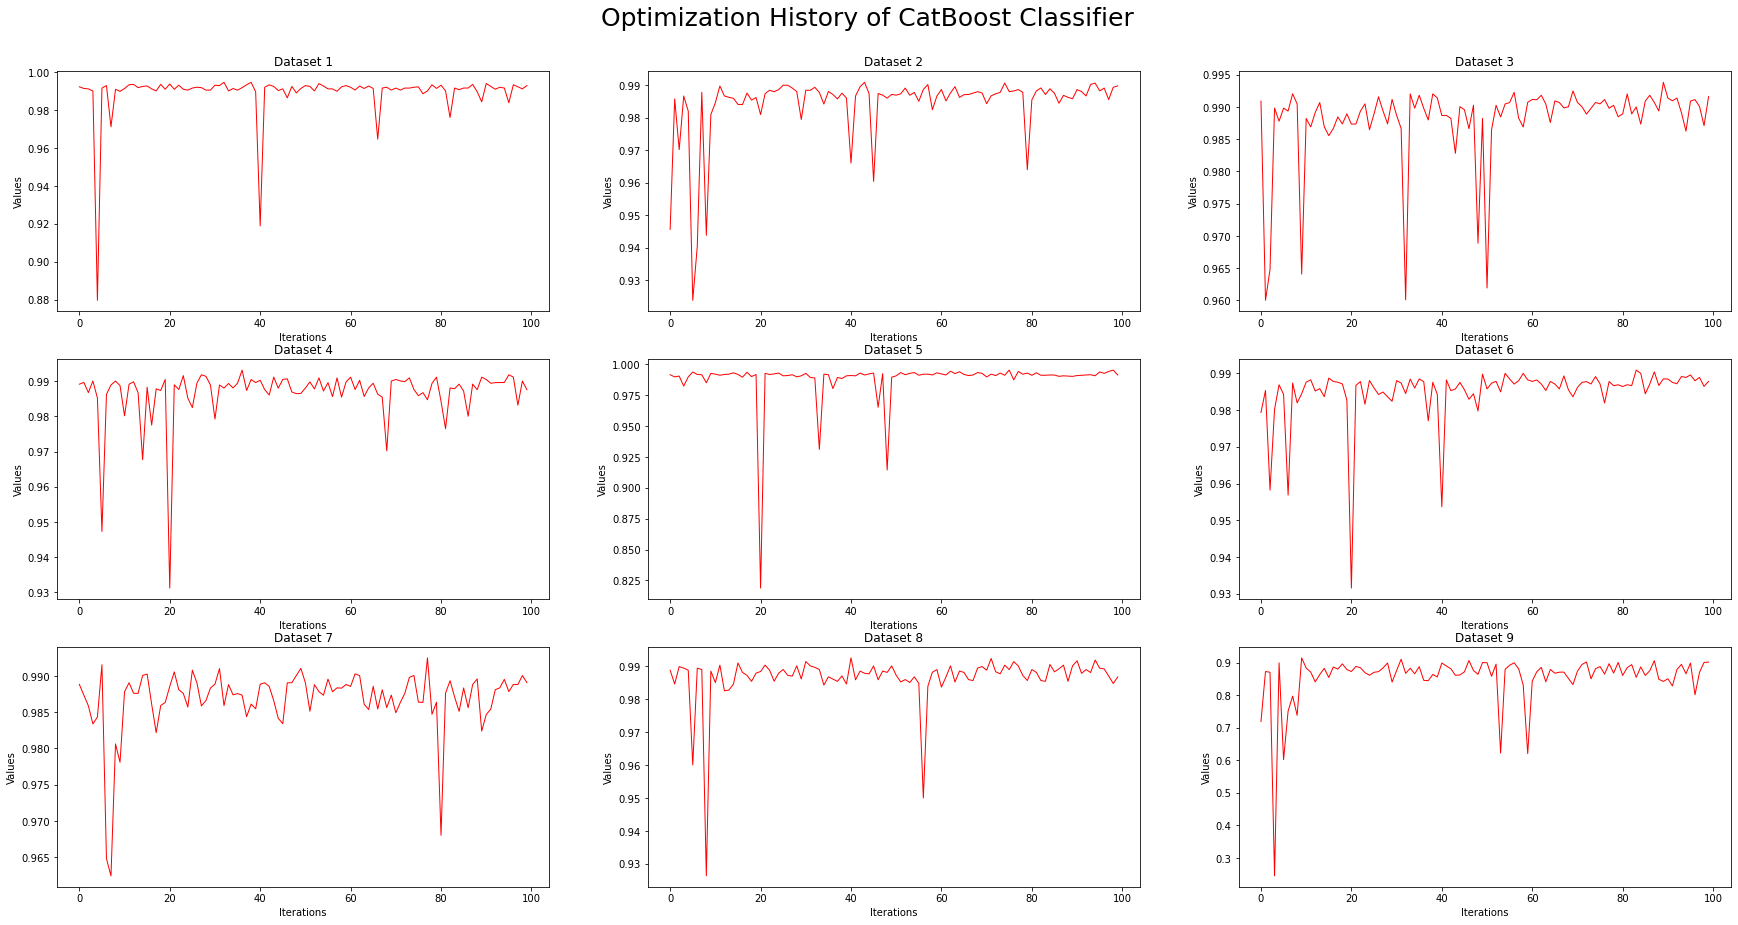

In [6]:
##### optimization history plot #####
optuna_history(best_paramC, all_scoreC, num_row = 3, num_col = 3, model = 'CatBoost Classifier')
            
##### best hyperparameter table #####
param_table = pd.DataFrame(best_paramC).T
param_table

#### Classifier

0it [00:00, ?it/s]


 Dataset1:
Precision: 0.002182972812065886 
Recall: 0.21568627450980393 
Aging Rate: 0.10357869637608173

 Dataset2:
Precision: 0.0010175763182238668 
Recall: 0.21568627450980393 
Aging Rate: 0.2222039507492446

 Dataset3:
Precision: 0.0010673877463886715 
Recall: 0.29411764705882354 
Aging Rate: 0.288865135974018

 Dataset4:
Precision: 0.001533528509689112 
Recall: 0.21568627450980393 
Aging Rate: 0.1474439351271352

 Dataset5:
Precision: 0.0011730205278592375 
Recall: 0.23529411764705882 
Aging Rate: 0.21028181463133877

 Dataset6:
Precision: 0.0014638906961613532 
Recall: 0.35294117647058826 
Aging Rate: 0.25274928569960325

 Dataset7:
Precision: 0.0012949640287769784 
Recall: 0.17647058823529413 
Aging Rate: 0.1428600793438714

 Dataset8:
Precision: 0.0008130081300813008 
Recall: 0.058823529411764705 
Aging Rate: 0.0758494521984008

 Dataset9:
Precision: 0.000946969696969697 
Recall: 0.21568627450980393 
Aging Rate: 0.2387716088717137


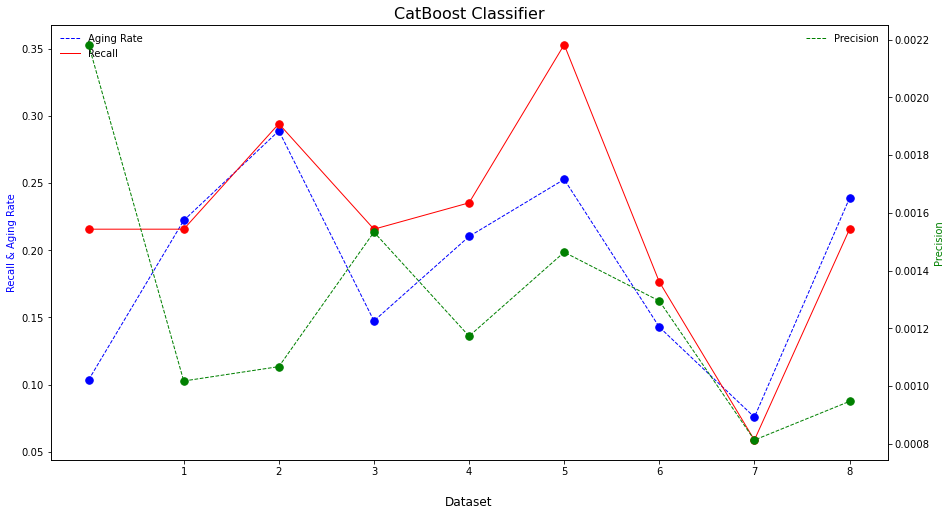

In [41]:
table_setC = runall_CatBoostC(run_train_x, run_test_x, run_train_y, run_test_y, best_paramC)
line_chart(table_setC, title = 'CatBoost Classifier')

In [42]:
table_setC

,Balance Ratio,Train_OK,Train_NG,TP,FP,FN,TN,Precision,Recall,Aging Rate,Efficiency,F1 Score,Score
dataset1,1.000000,3067.0,3067.0,11.0,5028.0,40.0,43570.0,0.002183,0.215686,0.103579,2.082342,0.002161,0.242796
dataset2,1.000000,3004.0,3004.0,11.0,10799.0,40.0,37799.0,0.001018,0.215686,0.222204,0.970668,0.001013,0.000000
dataset3,1.000000,3033.0,3033.0,15.0,14038.0,36.0,34560.0,0.001067,0.294118,0.288865,1.018183,0.001064,0.206529
dataset4,1.000000,3038.0,3038.0,11.0,7162.0,40.0,41436.0,0.001534,0.215686,0.147444,1.462836,0.001523,0.194401
dataset5,1.006623,3040.0,3020.0,12.0,10218.0,39.0,38380.0,0.001173,0.235294,0.210282,1.118947,0.001167,0.176687
dataset6,1.011984,3040.0,3004.0,18.0,12278.0,33.0,36320.0,0.001464,0.352941,0.252749,1.396408,0.001458,0.308460
dataset7,1.099458,3040.0,2765.0,9.0,6941.0,42.0,41657.0,0.001295,0.176471,0.142860,1.235269,0.001286,0.141946
dataset8,1.000000,3040.0,3040.0,3.0,3687.0,48.0,44911.0,0.000813,0.058824,0.075849,0.775530,0.000802,0.000000
dataset9,10.000000,3040.0,304.0,11.0,11605.0,40.0,36993.0,0.000947,0.215686,0.238772,0.903316,0.000943,0.000000


#### Calibrated Classifier (optional)

In [ ]:
tableC_1 = all_cali_CatBoostC(run_train_x, run_train_y, run_test_x, run_test_y, best_paramC, method = 'isotonic')
tableC_2 = all_cali_CatBoostC(run_train_x, run_train_y, run_test_x, run_test_y, best_paramC, method = 'sigmoid')
tableC_3 = all_cali_CatBoostC(run_train_x, run_train_y, run_test_x, run_test_y, best_paramC, method = 'beta')

#### Regressor (optional)

In [ ]:
best_paramR, all_scoreR = all_optuna(num_set = 10, 
                                     all_data = run_train, 
                                     mode = 'R', 
                                     TPE_multi = False, 
                                     n_iter = 200,
                                     filename = 'runhist_array_m2m5_4selection_CatBoost',
                                     creator = CatBoost_creator
                                    )

In [ ]:
pr_dict, table_setR = runall_CatBoostR(10, trainset_x, run_test_x, trainset_y, run_test_y, best_paramR, cat_feature = [], 
                                       thres_target = 'Recall', threshold = 0.8)
line_chart(table_setR, title = 'CatBoost Regressor')

In [ ]:
multiple_curve(4, 3, pr_dict, table_setR, target = 'Aging Rate')
multiple_curve(4, 3, pr_dict, table_setR, target = 'Precision')
table_setR

### Full Experiment

In [7]:
training_month = range(2, 5)
table_setC = full_catboost(training_month, times = 3)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Month 2:
# bad: 69
Size before Border: 39009
Distance = 1 ...
Distance = 2 ...
Distance = 3 ...
Distance = 4 ...
Distance = 5 ...
Distance = 6 ...
Distance = 7 ...
Distance = 8 ...
# over: 10
Distance = 9 ...
# over: 10
Distance = 10 ...
# over: 10
Distance = 11 ...
# over: 50
Distance = 12 ...
# over: 30
Distance = 13 ...
# over: 70
Distance = 14 ...
# over: 70
Distance = 15 ...
# over: 240
Distance = 16 ...
# over: 155
# over: 155
Size after Border: 39617

 Generating Dataset 2
Size after Undersampling: 1354
Size after Undersampling: (1354, 88) , Balance Ratio: 1.0
Size before Undersampling: 39009

 Generating Dataset 6
Size after Undersampling: 759
Size after Undersampling: 759
Distance = 1 ...
Distance = 2 ...
Distance = 3 ...
Distance = 4 ...
Distance = 5 ...
Distance = 6 ...
Distance = 7 ...
Distance = 8 ...
# over: 10
Distance = 9 ...
# over: 10
Distance = 10 ...
# over: 10
Distance = 11 ...
# over: 50
Distance = 12 ...
# over: 30
Distance = 13 ...
# over: 70
Distance = 14 ...
#

  0%|          | 0/9 [00:00<?, ?it/s]

[I 2022-04-01 13:36:07,531] A new study created in memory with name: no-name-afa86895-c83a-4fa0-9e47-38f703089b09


Dataset 1 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9895833333333334 
Recall: 0.9908735332464146 
Aging Rate: 0.500651890482399
Precision: 0.9947643979057592 
Recall: 0.9908735332464146 
Aging Rate: 0.4980443285528031
Precision: 0.9921875 
Recall: 0.9934810951760105 
Aging Rate: 0.500651890482399
[I 2022-04-01 13:36:19,714] Trial 0 finished with value: 0.9919590142484208 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 500, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.0936279069845122}. Best is trial 0 with value: 0.9919590142484208.
Precision: 0.996078431372549 
Recall: 0.9934810951760105 
Aging Rate: 0.49869621903520206
Precision: 0.9857697283311773 
Recall: 0.9934810951760105 
Aging Rate: 0.5039113428943938
Precision: 0.9935064935064936 
Recall: 0.9973924380704041 
Aging Rate: 0.5019556714471969
[I 2022-04-01 13:36:22,210] Trial 1 finished with value: 0.9932780436284091 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.17500000000000002,

Precision: 0.9869791666666666 
Recall: 0.9882659713168188 
Aging Rate: 0.500651890482399
Precision: 0.9908854166666666 
Recall: 0.9921773142112125 
Aging Rate: 0.500651890482399
[I 2022-04-01 13:37:21,214] Trial 14 finished with value: 0.991528961472293 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 12, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 3.775419412991583, 'min_data_in_leaf': 60}. Best is trial 13 with value: 0.9947803387840586.
Precision: 0.9934383202099738 
Recall: 0.9869621903520208 
Aging Rate: 0.49674054758800523
Precision: 0.9934810951760105 
Recall: 0.9934810951760105 
Aging Rate: 0.5
Precision: 0.9921773142112125 
Recall: 0.9921773142112125 
Aging Rate: 0.5
[I 2022-04-01 13:37:24,893] Trial 15 finished with value: 0.9919493586119607 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 12, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 4.541117362373808, 'min_data_in_leaf': 20}. Best is t

[I 2022-04-01 13:37:43,716] A new study created in memory with name: no-name-e1eb9fa6-5064-405b-a4a9-dd7a8711c76d


Precision: 0.9934810951760105 
Recall: 0.9934810951760105 
Aging Rate: 0.5
[I 2022-04-01 13:37:43,669] Trial 24 finished with value: 0.9910659426575332 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 12, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.5020041515709255, 'min_data_in_leaf': 45}. Best is trial 13 with value: 0.9947803387840586.
Sampler is TPESampler
Dataset 2 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9663526244952894 
Recall: 0.9598930481283422 
Aging Rate: 0.4966577540106952
Precision: 0.9657444005270093 
Recall: 0.9799465240641712 
Aging Rate: 0.5073529411764706
Precision: 0.9563492063492064 
Recall: 0.9665775401069518 
Aging Rate: 0.5053475935828877
[I 2022-04-01 13:37:57,531] Trial 0 finished with value: 0.9657806017687429 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 12, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 4.751243437937338}. Best is trial 0 with value: 0.9657806017687429.
Precision: 0.8285714285714286 
Recall: 0.7754010695187166 
Aging Rate: 0.4679144385026738
Precision: 0.847124824684432 
Recall: 0.8074866310160428 
Aging Rate: 0.4766042780748663
Precision: 0.8437935843793585 
Recall: 0.8088235294117647 
Aging Rate: 0.47927807486631013
[I 2022-04-01 13:37:58,871] Trial 1 finished with value: 0.8179581588808286 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 2, 'learning_rate': 0.025

Precision: 0.9905277401894452 
Recall: 0.9786096256684492 
Aging Rate: 0.4939839572192513
Precision: 0.9827127659574468 
Recall: 0.9879679144385026 
Aging Rate: 0.5026737967914439
[I 2022-04-01 13:39:39,141] Trial 14 finished with value: 0.9859659547441101 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 500, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.1315773499636751}. Best is trial 13 with value: 0.9908731895538442.
Precision: 0.9865771812080537 
Recall: 0.982620320855615 
Aging Rate: 0.4979946524064171
Precision: 0.9763157894736842 
Recall: 0.9919786096256684 
Aging Rate: 0.5080213903743316
Precision: 0.9853333333333333 
Recall: 0.9879679144385026 
Aging Rate: 0.5013368983957219
[I 2022-04-01 13:39:43,736] Trial 15 finished with value: 0.9851095071365669 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.12178287711264396, 'min_data_in_leaf': 30}. Best is tr

[I 2022-04-01 13:43:21,987] A new study created in memory with name: no-name-27c0d347-3e40-4edd-850f-a9ef99ae492a


Precision: 0.9801849405548216 
Recall: 0.9919786096256684 
Aging Rate: 0.5060160427807486
[I 2022-04-01 13:43:21,940] Trial 24 finished with value: 0.9844017028567458 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 500, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 2.4341012808663396}. Best is trial 13 with value: 0.9908731895538442.
Sampler is TPESampler
Dataset 3 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 1.0 
Recall: 0.9434210526315789 
Aging Rate: 0.47171052631578947
Precision: 0.9985855728429985 
Recall: 0.9289473684210526 
Aging Rate: 0.4651315789473684
Precision: 1.0 
Recall: 0.9342105263157895 
Aging Rate: 0.46710526315789475
[I 2022-04-01 13:43:25,169] Trial 0 finished with value: 0.9664606161069312 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.3852616553095851, 'min_data_in_leaf': 10, 'max_leaves': 35}. Best is trial 0 with value: 0.9664606161069312.
Precision: 1.0 
Recall: 0.9907894736842106 
Aging Rate: 0.4953947368421053
Precision: 1.0 
Recall: 0.9842105263157894 
Aging Rate: 0.4921052631578947
Precision: 0.9973262032085561 
Recall: 0.9815789473684211 
Aging Rate: 0.4921052631578947
[I 2022-04-01 13:46:04,843] Trial 1 finished with value: 0.9922685970045636 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 500, 'depth': 10, 'learning_rate': 0.07500000000000001, 'su

Precision: 0.9986666666666667 
Recall: 0.9855263157894737 
Aging Rate: 0.4934210526315789
Precision: 1.0 
Recall: 0.9802631578947368 
Aging Rate: 0.4901315789473684
Precision: 0.9973118279569892 
Recall: 0.9763157894736842 
Aging Rate: 0.48947368421052634
[I 2022-04-01 14:12:07,131] Trial 15 finished with value: 0.9895961101277958 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 500, 'depth': 12, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.18084475511123146}. Best is trial 14 with value: 0.9922737846227654.
Precision: 1.0 
Recall: 0.9855263157894737 
Aging Rate: 0.49276315789473685
Precision: 0.9972936400541272 
Recall: 0.9697368421052631 
Aging Rate: 0.4861842105263158
Precision: 1.0 
Recall: 0.9855263157894737 
Aging Rate: 0.49276315789473685
[I 2022-04-01 14:13:43,851] Trial 16 finished with value: 0.989581007764104 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsam

[I 2022-04-01 14:17:30,313] A new study created in memory with name: no-name-0814271e-5b17-461a-b860-92f1f7280f43


Precision: 1.0 
Recall: 0.9842105263157894 
Aging Rate: 0.4921052631578947
[I 2022-04-01 14:17:30,266] Trial 24 finished with value: 0.9922747181879993 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 12, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.010595476771853069, 'min_data_in_leaf': 50}. Best is trial 24 with value: 0.9922747181879993.
Sampler is TPESampler
Dataset 4 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9893475366178429 
Recall: 0.9776315789473684 
Aging Rate: 0.49407894736842106
Precision: 0.9906166219839142 
Recall: 0.9723684210526315 
Aging Rate: 0.49078947368421055
Precision: 0.9893899204244032 
Recall: 0.9815789473684211 
Aging Rate: 0.49605263157894736
[I 2022-04-01 14:17:31,166] Trial 0 finished with value: 0.9834437749047863 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 8.98216245628589, 'min_data_in_leaf': 40}. Best is trial 0 with value: 0.9834437749047863.
Precision: 0.9946666666666667 
Recall: 0.9815789473684211 
Aging Rate: 0.4934210526315789
Precision: 0.9986702127659575 
Recall: 0.9881578947368421 
Aging Rate: 0.49473684210526314
Precision: 0.993368700265252 
Recall: 0.9855263157894737 
Aging Rate: 0.49605263157894736
[I 2022-04-01 14:18:03,405] Trial 1 finished with value: 0.9902992272936079 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300

Precision: 0.9986666666666667 
Recall: 0.9855263157894737 
Aging Rate: 0.4934210526315789
Precision: 0.9973509933774835 
Recall: 0.9907894736842106 
Aging Rate: 0.4967105263157895
Precision: 0.9933774834437086 
Recall: 0.9868421052631579 
Aging Rate: 0.4967105263157895
[I 2022-04-01 14:19:58,385] Trial 14 finished with value: 0.9920704653246782 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.3, 'l2_leaf_reg': 1.2980320704516628}. Best is trial 14 with value: 0.9920704653246782.
Precision: 0.9933774834437086 
Recall: 0.9868421052631579 
Aging Rate: 0.4967105263157895
Precision: 0.9973154362416108 
Recall: 0.9776315789473684 
Aging Rate: 0.4901315789473684
Precision: 0.9960106382978723 
Recall: 0.9855263157894737 
Aging Rate: 0.49473684210526314
[I 2022-04-01 14:20:01,854] Trial 15 finished with value: 0.989405055308041 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 8, 'learning_rate': 0.225,

[I 2022-04-01 14:20:48,630] A new study created in memory with name: no-name-e5ab25e5-3081-49a8-92b7-7367c9da684e


Precision: 0.9920212765957447 
Recall: 0.9815789473684211 
Aging Rate: 0.49473684210526314
[I 2022-04-01 14:20:48,584] Trial 24 finished with value: 0.9892035026460787 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.8508808313379908, 'min_data_in_leaf': 30}. Best is trial 14 with value: 0.9920704653246782.
Sampler is TPESampler
Dataset 5 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9436435124508519 
Recall: 0.9536423841059603 
Aging Rate: 0.5036303630363036
Precision: 0.9540078843626807 
Recall: 0.9615894039735099 
Aging Rate: 0.5023102310231023
Precision: 0.9629139072847682 
Recall: 0.9629139072847682 
Aging Rate: 0.49834983498349833
[I 2022-04-01 14:20:50,026] Trial 0 finished with value: 0.9564380497454107 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 2, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.6171612163136494, 'min_data_in_leaf': 15}. Best is trial 0 with value: 0.9564380497454107.
Precision: 0.9344729344729344 
Recall: 0.8688741721854305 
Aging Rate: 0.4633663366336634
Precision: 0.92 
Recall: 0.8834437086092716 
Aging Rate: 0.47854785478547857
Precision: 0.9005449591280654 
Recall: 0.8754966887417218 
Aging Rate: 0.4844884488448845
[I 2022-04-01 14:21:02,090] Trial 1 finished with value: 0.8965586604473791 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 500, 'depth': 2, 'learning_rate

Precision: 0.9907529722589168 
Recall: 0.9933774834437086 
Aging Rate: 0.4996699669966997
Precision: 0.9973368841544608 
Recall: 0.9920529801324504 
Aging Rate: 0.4957095709570957
Precision: 0.9855832241153342 
Recall: 0.9960264900662251 
Aging Rate: 0.5036303630363036
[I 2022-04-01 14:21:43,981] Trial 14 finished with value: 0.9925095818911859 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 7.01544997918916, 'min_data_in_leaf': 25}. Best is trial 12 with value: 0.9942569304869906.
Precision: 0.9182305630026809 
Recall: 0.9072847682119205 
Aging Rate: 0.4924092409240924
Precision: 0.9373333333333334 
Recall: 0.9311258278145695 
Aging Rate: 0.49504950495049505
Precision: 0.899736147757256 
Recall: 0.9033112582781457 
Aging Rate: 0.5003300330033004
[I 2022-04-01 14:21:44,969] Trial 15 finished with value: 0.9161547592760572 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'd

[I 2022-04-01 14:22:01,339] A new study created in memory with name: no-name-97721e1d-682b-4457-827a-d0fa040dfd1b


Precision: 0.981675392670157 
Recall: 0.9933774834437086 
Aging Rate: 0.5042904290429043
[I 2022-04-01 14:22:01,283] Trial 24 finished with value: 0.9903005172605502 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.24715128422908283, 'min_data_in_leaf': 30, 'max_leaves': 30}. Best is trial 12 with value: 0.9942569304869906.
Sampler is TPESampler
Dataset 6 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.8808139534883721 
Recall: 0.8069241011984021 
Aging Rate: 0.4553275976174719
Precision: 0.874095513748191 
Recall: 0.8042609853528628 
Aging Rate: 0.457313037723362
Precision: 0.8601997146932953 
Recall: 0.8029294274300932 
Aging Rate: 0.4639311714096625
[I 2022-04-01 14:22:01,928] Trial 0 finished with value: 0.8368518191324066 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 2, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 4.399705539294262, 'min_data_in_leaf': 25, 'max_leaves': 20}. Best is trial 0 with value: 0.8368518191324066.
Precision: 0.9906790945406125 
Recall: 0.9906790945406125 
Aging Rate: 0.49702183984116477
Precision: 0.9932975871313673 
Recall: 0.9866844207723036 
Aging Rate: 0.4937127729980146
Precision: 0.9893048128342246 
Recall: 0.9853528628495339 
Aging Rate: 0.49503639973527463
[I 2022-04-01 14:22:05,377] Trial 1 finished with value: 0.9893279792386519 and parameters: {'grow_policy': 'Lossguide', 'itera

Precision: 0.989247311827957 
Recall: 0.9800266311584553 
Aging Rate: 0.4923891462607545
Precision: 0.9919678714859438 
Recall: 0.9866844207723036 
Aging Rate: 0.4943745863666446
Precision: 0.9840848806366048 
Recall: 0.9880159786950732 
Aging Rate: 0.4990072799470549
[I 2022-04-01 14:23:10,129] Trial 14 finished with value: 0.9866603294553741 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 1.6790689278710873, 'min_data_in_leaf': 20, 'max_leaves': 40}. Best is trial 1 with value: 0.9893279792386519.
Precision: 0.9841688654353562 
Recall: 0.9933422103861518 
Aging Rate: 0.5016545334215751
Precision: 0.9865951742627346 
Recall: 0.9800266311584553 
Aging Rate: 0.4937127729980146
Precision: 0.9803921568627451 
Recall: 0.9986684420772304 
Aging Rate: 0.5062872270019855
[I 2022-04-01 14:23:12,896] Trial 15 finished with value: 0.9871600348633455 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300,

[I 2022-04-01 14:28:36,303] A new study created in memory with name: no-name-c4784c19-7294-4441-91dc-0c0ca84c02b0


Precision: 0.9906666666666667 
Recall: 0.9893475366178429 
Aging Rate: 0.49636002647253474
[I 2022-04-01 14:28:36,272] Trial 24 finished with value: 0.990913538247851 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.18711287117782374}. Best is trial 24 with value: 0.990913538247851.
Sampler is TPESampler
Dataset 7 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 1.0 
Recall: 0.9736842105263158 
Aging Rate: 0.4868421052631579
Precision: 1.0 
Recall: 0.9697368421052631 
Aging Rate: 0.48486842105263156
Precision: 0.9973190348525469 
Recall: 0.9789473684210527 
Aging Rate: 0.49078947368421055
[I 2022-04-01 14:35:08,548] Trial 0 finished with value: 0.9864501379917869 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 12, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.08170415698471155}. Best is trial 0 with value: 0.9864501379917869.
Precision: 1.0 
Recall: 0.9302631578947368 
Aging Rate: 0.4651315789473684
Precision: 0.9957081545064378 
Recall: 0.9157894736842105 
Aging Rate: 0.4598684210526316
Precision: 0.9971870604781997 
Recall: 0.9328947368421052 
Aging Rate: 0.4677631578947368
[I 2022-04-01 14:35:09,269] Trial 1 finished with value: 0.9606400237973584 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 2, 'learning_rate': 0.17500000000000002, 'subsample': 0.3, 'l2_leaf_re

Precision: 0.9946737683089214 
Recall: 0.9828947368421053 
Aging Rate: 0.49407894736842106
[I 2022-04-01 14:39:13,029] Trial 14 finished with value: 0.9869050951926766 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 7.956771560095006, 'min_data_in_leaf': 20, 'max_leaves': 25}. Best is trial 3 with value: 0.9924997366246616.
Precision: 0.9986504723346828 
Recall: 0.9736842105263158 
Aging Rate: 0.4875
Precision: 1.0 
Recall: 0.9828947368421053 
Aging Rate: 0.49144736842105263
Precision: 0.9986702127659575 
Recall: 0.9881578947368421 
Aging Rate: 0.49473684210526314
[I 2022-04-01 14:39:29,425] Trial 15 finished with value: 0.9902563868050785 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.025922505845642894}. Best is trial 3 with value: 0.9924997366246616.
Precision: 0.9946949602122016 
Recall: 0.9868421052631579 

[I 2022-04-01 14:40:00,357] A new study created in memory with name: no-name-52112998-fd50-4d18-96bc-e65aace47415


Precision: 0.9945054945054945 
Recall: 0.9526315789473684 
Aging Rate: 0.4789473684210526
[I 2022-04-01 14:40:00,305] Trial 24 finished with value: 0.9712476465030604 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 2, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.03234247471923497, 'min_data_in_leaf': 35}. Best is trial 3 with value: 0.9924997366246616.
Sampler is TPESampler
Dataset 8 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9920739762219286 
Recall: 0.9881578947368421 
Aging Rate: 0.4980263157894737
Precision: 1.0 
Recall: 0.9894736842105263 
Aging Rate: 0.49473684210526314
Precision: 0.9947159841479525 
Recall: 0.9907894736842106 
Aging Rate: 0.4980263157894737
[I 2022-04-01 14:40:04,012] Trial 0 finished with value: 0.9925233014663909 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.904748961750002, 'min_data_in_leaf': 60}. Best is trial 0 with value: 0.9925233014663909.
Precision: 0.9573643410852714 
Recall: 0.975 
Aging Rate: 0.5092105263157894
Precision: 0.9644268774703557 
Recall: 0.9631578947368421 
Aging Rate: 0.4993421052631579
Precision: 0.9633507853403142 
Recall: 0.968421052631579 
Aging Rate: 0.5026315789473684
[I 2022-04-01 14:40:19,120] Trial 1 finished with value: 0.9652576428024604 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 500, 'depth': 2, 'learning_rate': 0.125, 'subsam

Precision: 0.9893758300132802 
Recall: 0.9802631578947368 
Aging Rate: 0.4953947368421053
[I 2022-04-01 14:41:20,253] Trial 14 finished with value: 0.9887605259591986 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 1.8178376501314577, 'min_data_in_leaf': 15}. Best is trial 0 with value: 0.9925233014663909.
Precision: 0.9840848806366048 
Recall: 0.9763157894736842 
Aging Rate: 0.49605263157894736
Precision: 0.9919786096256684 
Recall: 0.9763157894736842 
Aging Rate: 0.4921052631578947
Precision: 0.9959946595460614 
Recall: 0.9815789473684211 
Aging Rate: 0.49276315789473685
[I 2022-04-01 14:41:22,858] Trial 15 finished with value: 0.9843346940971642 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.4955166433755925, 'min_data_in_leaf': 20}. Best is trial 0 with value: 0.9925233014663909.
Precision: 0.9959839357429718 


[I 2022-04-01 14:41:42,052] A new study created in memory with name: no-name-e66e77eb-33f0-44cf-bbef-289eba370998


Precision: 0.9959893048128342 
Recall: 0.9802631578947368 
Aging Rate: 0.4921052631578947
[I 2022-04-01 14:41:42,005] Trial 24 finished with value: 0.9885601582890837 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 1.253371348114793, 'min_data_in_leaf': 15}. Best is trial 23 with value: 0.9940593840925783.
Sampler is TPESampler
Dataset 9 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9264705882352942 
Recall: 0.8289473684210527 
Aging Rate: 0.08133971291866028
Precision: 0.8787878787878788 
Recall: 0.7631578947368421 
Aging Rate: 0.07894736842105263
Precision: 0.90625 
Recall: 0.7631578947368421 
Aging Rate: 0.07655502392344497
[I 2022-04-01 14:41:43,389] Trial 0 finished with value: 0.840157612340711 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.3, 'l2_leaf_reg': 3.828446647058993, 'min_data_in_leaf': 45, 'max_leaves': 45}. Best is trial 0 with value: 0.840157612340711.
Precision: 0.9736842105263158 
Recall: 0.4868421052631579 
Aging Rate: 0.045454545454545456
Precision: 0.9722222222222222 
Recall: 0.4605263157894737 
Aging Rate: 0.0430622009569378
Precision: 0.8947368421052632 
Recall: 0.4473684210526316 
Aging Rate: 0.045454545454545456
[I 2022-04-01 14:41:44,096] Trial 1 finished with value: 0.6235380116959065 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth'

Precision: 1.0 
Recall: 0.7631578947368421 
Aging Rate: 0.06937799043062201
[I 2022-04-01 14:43:05,308] Trial 14 finished with value: 0.8772529240289361 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.3, 'l2_leaf_reg': 0.023633309785157028, 'min_data_in_leaf': 5}. Best is trial 2 with value: 0.8991228167534232.
Precision: 0.9193548387096774 
Recall: 0.75 
Aging Rate: 0.07416267942583732
Precision: 0.9696969696969697 
Recall: 0.8421052631578947 
Aging Rate: 0.07894736842105263
Precision: 0.984375 
Recall: 0.8289473684210527 
Aging Rate: 0.07655502392344497
[I 2022-04-01 14:43:08,763] Trial 15 finished with value: 0.8758318024086548 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.10697088610973703, 'min_data_in_leaf': 25}. Best is trial 2 with value: 0.8991228167534232.
Precision: 0.9838709677419355 
Recall: 0.8026315789473685 
Aging R

  0%|          | 0/3 [00:00<?, ?it/s]

Month 2:
# bad: 69
Size before Border: 39009
Distance = 1 ...
Distance = 2 ...
Distance = 3 ...
Distance = 4 ...
Distance = 5 ...
Distance = 6 ...
Distance = 7 ...
Distance = 8 ...
# over: 10
Distance = 9 ...
# over: 10
Distance = 10 ...
# over: 10
Distance = 11 ...
# over: 50
Distance = 12 ...
# over: 30
Distance = 13 ...
# over: 70
Distance = 14 ...
# over: 70
Distance = 15 ...
# over: 240
Distance = 16 ...
# over: 155
# over: 155
Size after Border: 39622

 Generating Dataset 2
Size after Undersampling: 1364
Size after Undersampling: (1364, 88) , Balance Ratio: 1.0
Size before Undersampling: 39009

 Generating Dataset 6
Size after Undersampling: 759
Size after Undersampling: 759
Distance = 1 ...
Distance = 2 ...
Distance = 3 ...
Distance = 4 ...
Distance = 5 ...
Distance = 6 ...
Distance = 7 ...
Distance = 8 ...
# over: 10
Distance = 9 ...
# over: 10
Distance = 10 ...
# over: 10
Distance = 11 ...
# over: 50
Distance = 12 ...
# over: 30
Distance = 13 ...
# over: 70
Distance = 14 ...
#

  0%|          | 0/9 [00:00<?, ?it/s]

[I 2022-04-01 14:45:26,538] A new study created in memory with name: no-name-5ef34e71-5764-4b47-a359-6bdab26a576f


Dataset 1 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9870633893919794 
Recall: 0.9947848761408083 
Aging Rate: 0.5039113428943938
Precision: 0.9819587628865979 
Recall: 0.9934810951760105 
Aging Rate: 0.5058670143415906
Precision: 0.993455497382199 
Recall: 0.9895697522816167 
Aging Rate: 0.4980443285528031
[I 2022-04-01 14:45:31,400] Trial 0 finished with value: 0.9900347446718344 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.075272429370788}. Best is trial 0 with value: 0.9900347446718344.
Precision: 0.9895968790637191 
Recall: 0.9921773142112125 
Aging Rate: 0.5013037809647979
Precision: 0.988296488946684 
Recall: 0.9908735332464146 
Aging Rate: 0.5013037809647979
Precision: 0.9870298313878081 
Recall: 0.9921773142112125 
Aging Rate: 0.5026075619295959
[I 2022-04-01 14:45:42,555] Trial 1 finished with value: 0.9900218763545731 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 12, 'learning_rate': 0.225, 

Precision: 0.993421052631579 
Recall: 0.984354628422425 
Aging Rate: 0.4954367666232073
Precision: 0.9973821989528796 
Recall: 0.9934810951760105 
Aging Rate: 0.4980443285528031
[I 2022-04-01 14:47:31,844] Trial 14 finished with value: 0.9919456164705368 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 500, 'depth': 12, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.010006457939297764}. Best is trial 13 with value: 0.9945617619827392.
Precision: 0.9960526315789474 
Recall: 0.9869621903520208 
Aging Rate: 0.4954367666232073
Precision: 0.9896238651102465 
Recall: 0.9947848761408083 
Aging Rate: 0.5026075619295959
Precision: 0.9947712418300654 
Recall: 0.9921773142112125 
Aging Rate: 0.49869621903520206
[I 2022-04-01 14:47:34,883] Trial 15 finished with value: 0.9923856063792714 and parameters: {'grow_policy': 'Lossguide', 'iterations': 500, 'depth': 4, 'learning_rate': 0.125, 'subsample': 0.3, 'l2_leaf_reg': 0.02196785832562632, 'min_data_in_leaf':

[I 2022-04-01 14:49:04,219] A new study created in memory with name: no-name-b1ae3f8c-7781-494c-a387-fbc653650c89


Precision: 0.9947848761408083 
Recall: 0.9947848761408083 
Aging Rate: 0.5
[I 2022-04-01 14:49:04,172] Trial 24 finished with value: 0.992176708018128 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 500, 'depth': 4, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.03370186607078916}. Best is trial 22 with value: 0.9956475305350171.
Sampler is TPESampler
Dataset 2 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9838926174496644 
Recall: 0.982573726541555 
Aging Rate: 0.49932975871313673
Precision: 0.9906291834002677 
Recall: 0.9919571045576407 
Aging Rate: 0.5006702412868632
Precision: 0.9892904953145917 
Recall: 0.9906166219839142 
Aging Rate: 0.5006702412868632
[I 2022-04-01 14:49:11,137] Trial 0 finished with value: 0.9881595145031086 and parameters: {'grow_policy': 'Lossguide', 'iterations': 500, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.012616419376004565, 'min_data_in_leaf': 30, 'max_leaves': 50}. Best is trial 0 with value: 0.9881595145031086.
Precision: 0.8894952251023193 
Recall: 0.8739946380697051 
Aging Rate: 0.4912868632707775
Precision: 0.8770718232044199 
Recall: 0.8512064343163539 
Aging Rate: 0.48525469168900803
Precision: 0.8715846994535519 
Recall: 0.8552278820375335 
Aging Rate: 0.4906166219839142
[I 2022-04-01 14:49:11,743] Trial 1 finished with value: 0.8696504032064042 and parameters: {'grow_policy': 'Lossguide', 'iterations': 1

Precision: 0.9906040268456375 
Recall: 0.9892761394101877 
Aging Rate: 0.49932975871313673
Precision: 0.9852348993288591 
Recall: 0.9839142091152815 
Aging Rate: 0.49932975871313673
Precision: 0.9840213049267643 
Recall: 0.9906166219839142 
Aging Rate: 0.5033512064343163
[I 2022-04-01 14:50:24,303] Trial 14 finished with value: 0.987273899464478 and parameters: {'grow_policy': 'Lossguide', 'iterations': 500, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.04431537049155924, 'min_data_in_leaf': 60, 'max_leaves': 35}. Best is trial 0 with value: 0.9881595145031086.
Precision: 0.9812834224598931 
Recall: 0.9839142091152815 
Aging Rate: 0.5013404825737265
Precision: 0.9865591397849462 
Recall: 0.9839142091152815 
Aging Rate: 0.49865951742627346
Precision: 0.9879518072289156 
Recall: 0.9892761394101877 
Aging Rate: 0.5006702412868632
[I 2022-04-01 14:50:25,822] Trial 15 finished with value: 0.9854818280069435 and parameters: {'grow_policy': 'Lossguide', 'iterations':

[I 2022-04-01 14:51:23,166] A new study created in memory with name: no-name-bcd7fe03-d519-45cf-a9b6-b5aab8fb00cc


Precision: 0.9852941176470589 
Recall: 0.9879356568364611 
Aging Rate: 0.5013404825737265
[I 2022-04-01 14:51:23,116] Trial 24 finished with value: 0.9854409716868324 and parameters: {'grow_policy': 'Lossguide', 'iterations': 500, 'depth': 12, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.02438516111877753, 'min_data_in_leaf': 25, 'max_leaves': 35}. Best is trial 0 with value: 0.9881595145031086.
Sampler is TPESampler
Dataset 3 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9931880108991825 
Recall: 0.9592105263157895 
Aging Rate: 0.48289473684210527
Precision: 0.9959239130434783 
Recall: 0.9644736842105263 
Aging Rate: 0.4842105263157895
Precision: 1.0 
Recall: 0.9828947368421053 
Aging Rate: 0.49144736842105263
[I 2022-04-01 14:51:24,400] Trial 0 finished with value: 0.9824079094785795 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 4, 'learning_rate': 0.225, 'subsample': 0.3, 'l2_leaf_reg': 0.012882991329404327, 'min_data_in_leaf': 5}. Best is trial 0 with value: 0.9824079094785795.
Precision: 0.9946666666666667 
Recall: 0.9815789473684211 
Aging Rate: 0.4934210526315789
Precision: 0.9973154362416108 
Recall: 0.9776315789473684 
Aging Rate: 0.4901315789473684
Precision: 0.997275204359673 
Recall: 0.9631578947368421 
Aging Rate: 0.48289473684210527
[I 2022-04-01 14:51:28,039] Trial 1 finished with value: 0.9851248547319758 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 500, 'depth': 4, 'learning_rate

Precision: 0.9959839357429718 
Recall: 0.9789473684210527 
Aging Rate: 0.49144736842105263
Precision: 1.0 
Recall: 0.9842105263157894 
Aging Rate: 0.4921052631578947
[I 2022-04-01 14:55:04,820] Trial 14 finished with value: 0.9902732111287974 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 3.0573002258975204, 'min_data_in_leaf': 35}. Best is trial 2 with value: 0.9920370583954542.
Precision: 0.9986449864498645 
Recall: 0.9697368421052631 
Aging Rate: 0.4855263157894737
Precision: 0.9986522911051213 
Recall: 0.975 
Aging Rate: 0.4881578947368421
Precision: 0.9986648865153538 
Recall: 0.9842105263157894 
Aging Rate: 0.49276315789473685
[I 2022-04-01 14:55:15,712] Trial 15 finished with value: 0.9873493607169058 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.16095549455463093, 'min_data_in_leaf': 20}. Best is trial 2 

[I 2022-04-01 14:57:50,062] A new study created in memory with name: no-name-f6c5b854-4e6e-4be5-872e-77f28b9663ab


Precision: 0.9986648865153538 
Recall: 0.9842105263157894 
Aging Rate: 0.49276315789473685
[I 2022-04-01 14:57:50,000] Trial 24 finished with value: 0.9869597439300826 and parameters: {'grow_policy': 'Lossguide', 'iterations': 500, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 1.3407259706581258, 'min_data_in_leaf': 55, 'max_leaves': 20}. Best is trial 2 with value: 0.9920370583954542.
Sampler is TPESampler
Dataset 4 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9973190348525469 
Recall: 0.9789473684210527 
Aging Rate: 0.49078947368421055
Precision: 0.99734395750332 
Recall: 0.9881578947368421 
Aging Rate: 0.4953947368421053
Precision: 0.9946452476572959 
Recall: 0.9776315789473684 
Aging Rate: 0.49144736842105263
[I 2022-04-01 14:57:57,582] Trial 0 finished with value: 0.9889475049219031 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.2508624832693304, 'min_data_in_leaf': 45}. Best is trial 0 with value: 0.9889475049219031.
Precision: 0.9972936400541272 
Recall: 0.9697368421052631 
Aging Rate: 0.4861842105263158
Precision: 0.9947019867549669 
Recall: 0.9881578947368421 
Aging Rate: 0.4967105263157895
Precision: 0.9959839357429718 
Recall: 0.9789473684210527 
Aging Rate: 0.49144736842105263
[I 2022-04-01 14:58:09,578] Trial 1 finished with value: 0.9873778421993289 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10,

Precision: 0.9919893190921228 
Recall: 0.9776315789473684 
Aging Rate: 0.49276315789473685
Precision: 0.9973333333333333 
Recall: 0.9842105263157894 
Aging Rate: 0.4934210526315789
Precision: 0.9959946595460614 
Recall: 0.9815789473684211 
Aging Rate: 0.49276315789473685
[I 2022-04-01 14:59:49,423] Trial 14 finished with value: 0.9880736186267237 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 12, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.03763233105776793, 'min_data_in_leaf': 5}. Best is trial 13 with value: 0.9909723768230552.
Precision: 0.9868593955321945 
Recall: 0.9881578947368421 
Aging Rate: 0.5006578947368421
Precision: 0.9920106524633822 
Recall: 0.9802631578947368 
Aging Rate: 0.49407894736842106
Precision: 0.9894459102902374 
Recall: 0.9868421052631579 
Aging Rate: 0.4986842105263158
[I 2022-04-01 14:59:54,816] Trial 15 finished with value: 0.9872508100087788 and parameters: {'grow_policy': 'Depthwise', 'iterations': 50

[I 2022-04-01 15:00:22,858] A new study created in memory with name: no-name-8afba2fd-5c49-4574-bb6d-53d42a86734f


Precision: 0.9920634920634921 
Recall: 0.9868421052631579 
Aging Rate: 0.49736842105263157
[I 2022-04-01 15:00:22,813] Trial 24 finished with value: 0.9885524515991956 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 12, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 2.389449793296126, 'min_data_in_leaf': 40}. Best is trial 21 with value: 0.9914153609676898.
Sampler is TPESampler
Dataset 5 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9920212765957447 
Recall: 0.9880794701986755 
Aging Rate: 0.49636963696369635
Precision: 1.0 
Recall: 0.990728476821192 
Aging Rate: 0.49372937293729374
Precision: 0.9973262032085561 
Recall: 0.9880794701986755 
Aging Rate: 0.49372937293729374
[I 2022-04-01 15:00:24,771] Trial 0 finished with value: 0.9926901339987575 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.5917450432300327, 'min_data_in_leaf': 30}. Best is trial 0 with value: 0.9926901339987575.
Precision: 0.9933598937583001 
Recall: 0.990728476821192 
Aging Rate: 0.497029702970297
Precision: 0.9946737683089214 
Recall: 0.9894039735099338 
Aging Rate: 0.4957095709570957
Precision: 0.9947019867549669 
Recall: 0.9947019867549669 
Aging Rate: 0.49834983498349833
[I 2022-04-01 15:00:42,851] Trial 1 finished with value: 0.9929254331944097 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 500, 'depth': 10, 

Precision: 0.9893758300132802 
Recall: 0.9867549668874173 
Aging Rate: 0.497029702970297
Precision: 0.9868247694334651 
Recall: 0.9920529801324504 
Aging Rate: 0.500990099009901
[I 2022-04-01 15:02:55,905] Trial 14 finished with value: 0.9889618497325873 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.16266096324194998, 'min_data_in_leaf': 5, 'max_leaves': 25}. Best is trial 4 with value: 0.9940339860592071.
Precision: 0.9893899204244032 
Recall: 0.9880794701986755 
Aging Rate: 0.4976897689768977
Precision: 0.9933510638297872 
Recall: 0.9894039735099338 
Aging Rate: 0.49636963696369635
Precision: 0.9933862433862434 
Recall: 0.9947019867549669 
Aging Rate: 0.499009900990099
[I 2022-04-01 15:02:59,156] Trial 15 finished with value: 0.9913838435653771 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 1.169707142291264, '

[I 2022-04-01 15:05:44,550] A new study created in memory with name: no-name-90a4a387-73d3-4422-bea4-f9aad7e5e899


Precision: 0.9947089947089947 
Recall: 0.9960264900662251 
Aging Rate: 0.499009900990099
[I 2022-04-01 15:05:44,486] Trial 24 finished with value: 0.9936091753425872 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 500, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.3, 'l2_leaf_reg': 3.348653770655041}. Best is trial 21 with value: 0.9944848870487637.
Sampler is TPESampler
Dataset 6 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9880636604774535 
Recall: 0.9946595460614153 
Aging Rate: 0.49966865473823724
Precision: 0.9973190348525469 
Recall: 0.9933244325767691 
Aging Rate: 0.4943671305500331
Precision: 0.9906666666666667 
Recall: 0.9919893190921228 
Aging Rate: 0.4970178926441352
[I 2022-04-01 15:05:48,514] Trial 0 finished with value: 0.9926653031742791 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.03722884506793816, 'min_data_in_leaf': 45}. Best is trial 0 with value: 0.9926653031742791.
Precision: 0.988 
Recall: 0.9893190921228304 
Aging Rate: 0.4970178926441352
Precision: 0.9801849405548216 
Recall: 0.9906542056074766 
Aging Rate: 0.5016567263088137
Precision: 0.9853917662682603 
Recall: 0.9906542056074766 
Aging Rate: 0.4990059642147117
[I 2022-04-01 15:05:54,273] Trial 1 finished with value: 0.9873556170113491 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, '

Precision: 0.9879839786381842 
Recall: 0.9879839786381842 
Aging Rate: 0.4963552021206097
Precision: 0.9893333333333333 
Recall: 0.9906542056074766 
Aging Rate: 0.4970178926441352
Precision: 0.9838709677419355 
Recall: 0.9773030707610146 
Aging Rate: 0.49304174950298213
[I 2022-04-01 15:07:53,241] Trial 14 finished with value: 0.9861844429858212 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 1.1339155923780528, 'min_data_in_leaf': 20}. Best is trial 0 with value: 0.9926653031742791.
Precision: 0.9920318725099602 
Recall: 0.9973297730307076 
Aging Rate: 0.4990059642147117
Precision: 0.9959677419354839 
Recall: 0.9893190921228304 
Aging Rate: 0.49304174950298213
Precision: 0.9892904953145917 
Recall: 0.986648865153538 
Aging Rate: 0.49502982107355864
[I 2022-04-01 15:07:54,932] Trial 15 finished with value: 0.9917579889131289 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 12, 

[I 2022-04-01 15:08:13,324] A new study created in memory with name: no-name-74d96550-5548-4785-8a8a-b98ab56ebe52


Precision: 0.9972972972972973 
Recall: 0.9853137516688919 
Aging Rate: 0.49039098740888004
[I 2022-04-01 15:08:13,279] Trial 24 finished with value: 0.9901935944399951 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 12, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.050672510114517864, 'min_data_in_leaf': 50}. Best is trial 0 with value: 0.9926653031742791.
Sampler is TPESampler
Dataset 7 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 1.0 
Recall: 0.9013157894736842 
Aging Rate: 0.4506578947368421
Precision: 1.0 
Recall: 0.9157894736842105 
Aging Rate: 0.45789473684210524
Precision: 1.0 
Recall: 0.9118421052631579 
Aging Rate: 0.45592105263157895
[I 2022-04-01 15:08:14,088] Trial 0 finished with value: 0.9526764494651005 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 2, 'learning_rate': 0.07500000000000001, 'subsample': 0.3, 'l2_leaf_reg': 0.4161306830633747, 'min_data_in_leaf': 5}. Best is trial 0 with value: 0.9526764494651005.
Precision: 0.996 
Recall: 0.9828947368421053 
Aging Rate: 0.4934210526315789
Precision: 0.9973009446693657 
Recall: 0.9723684210526315 
Aging Rate: 0.4875
Precision: 0.9973544973544973 
Recall: 0.9921052631578947 
Aging Rate: 0.49736842105263157
[I 2022-04-01 15:08:18,245] Trial 1 finished with value: 0.9896012702445556 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 500, 'depth': 4, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 

Precision: 0.9959623149394348 
Recall: 0.9736842105263158 
Aging Rate: 0.4888157894736842
Precision: 0.9960212201591512 
Recall: 0.9881578947368421 
Aging Rate: 0.49605263157894736
Precision: 0.9973262032085561 
Recall: 0.9815789473684211 
Aging Rate: 0.4921052631578947
[I 2022-04-01 15:09:26,541] Trial 15 finished with value: 0.9887203895895847 and parameters: {'grow_policy': 'Lossguide', 'iterations': 500, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.08988361526206057, 'min_data_in_leaf': 45, 'max_leaves': 50}. Best is trial 13 with value: 0.9916117690900735.
Precision: 0.9973190348525469 
Recall: 0.9789473684210527 
Aging Rate: 0.49078947368421055
Precision: 1.0 
Recall: 0.9736842105263158 
Aging Rate: 0.4868421052631579
Precision: 0.9973190348525469 
Recall: 0.9789473684210527 
Aging Rate: 0.49078947368421055
[I 2022-04-01 15:20:07,407] Trial 16 finished with value: 0.9875874280655156 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 500, 'dep

[I 2022-04-01 15:23:32,230] A new study created in memory with name: no-name-a2df84c7-8f1e-498b-90a0-fbb825320f45


Precision: 1.0 
Recall: 0.9776315789473684 
Aging Rate: 0.4888157894736842
[I 2022-04-01 15:23:32,183] Trial 24 finished with value: 0.9860211474305073 and parameters: {'grow_policy': 'Lossguide', 'iterations': 500, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.3, 'l2_leaf_reg': 2.05096592391457, 'min_data_in_leaf': 5, 'max_leaves': 40}. Best is trial 13 with value: 0.9916117690900735.
Sampler is TPESampler
Dataset 8 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9539473684210527 
Recall: 0.9539473684210527 
Aging Rate: 0.5
Precision: 0.9342783505154639 
Recall: 0.9539473684210527 
Aging Rate: 0.5105263157894737
Precision: 0.9359795134443022 
Recall: 0.9618421052631579 
Aging Rate: 0.5138157894736842
[I 2022-04-01 15:23:33,624] Trial 0 finished with value: 0.9488974576725449 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 2, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.07716201792458206, 'min_data_in_leaf': 55}. Best is trial 0 with value: 0.9488974576725449.
Precision: 0.9890560875512996 
Recall: 0.9513157894736842 
Aging Rate: 0.48092105263157897
Precision: 0.989145183175034 
Recall: 0.9592105263157895 
Aging Rate: 0.48486842105263156
Precision: 0.984 
Recall: 0.9710526315789474 
Aging Rate: 0.4934210526315789
[I 2022-04-01 15:24:00,207] Trial 1 finished with value: 0.973750084327026 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 500, 'depth': 4, 'learning_rate'

Precision: 0.995945945945946 
Recall: 0.9697368421052631 
Aging Rate: 0.4868421052631579
Precision: 0.9933422103861518 
Recall: 0.9815789473684211 
Aging Rate: 0.49407894736842106
[I 2022-04-01 15:25:21,118] Trial 14 finished with value: 0.9882717226026049 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.024190672082854598, 'min_data_in_leaf': 5}. Best is trial 11 with value: 0.9896113884225844.
Precision: 0.9894039735099338 
Recall: 0.9828947368421053 
Aging Rate: 0.4967105263157895
Precision: 0.996005326231691 
Recall: 0.9842105263157894 
Aging Rate: 0.49407894736842106
Precision: 0.9959946595460614 
Recall: 0.9815789473684211 
Aging Rate: 0.49276315789473685
[I 2022-04-01 15:25:23,654] Trial 15 finished with value: 0.9883152248106674 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.02490312213451768

[I 2022-04-01 15:25:48,181] A new study created in memory with name: no-name-ccb22748-357a-4c73-8aab-9b4241b555a7


Precision: 0.9920424403183024 
Recall: 0.9842105263157894 
Aging Rate: 0.49605263157894736
[I 2022-04-01 15:25:48,138] Trial 24 finished with value: 0.9880899682434147 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.042458470331394056, 'min_data_in_leaf': 35}. Best is trial 20 with value: 0.991203762071123.
Sampler is TPESampler
Dataset 9 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 1.0 
Recall: 0.3026315789473684 
Aging Rate: 0.02751196172248804
Precision: 0.8928571428571429 
Recall: 0.32894736842105265 
Aging Rate: 0.03349282296650718
Precision: 1.0 
Recall: 0.23684210526315788 
Aging Rate: 0.0215311004784689
[I 2022-04-01 15:25:50,765] Trial 0 finished with value: 0.44279813960665027 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 6, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.022109992176073127}. Best is trial 0 with value: 0.44279813960665027.
Precision: 0.9803921568627451 
Recall: 0.6578947368421053 
Aging Rate: 0.061004784688995214
Precision: 1.0 
Recall: 0.7631578947368421 
Aging Rate: 0.06937799043062201
Precision: 0.9821428571428571 
Recall: 0.7236842105263158 
Aging Rate: 0.06698564593301436
[I 2022-04-01 15:26:01,158] Trial 1 finished with value: 0.828802183309176 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 12, 'learning_rate': 0.07500000000000001, 'subsample': 0.9,

Precision: 0.9420289855072463 
Recall: 0.8552631578947368 
Aging Rate: 0.08253588516746412
[I 2022-04-01 15:26:39,292] Trial 14 finished with value: 0.8962356280247487 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 12, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.010930421396556176, 'min_data_in_leaf': 45, 'max_leaves': 10}. Best is trial 12 with value: 0.9127382408086738.
Precision: 0.9523809523809523 
Recall: 0.7894736842105263 
Aging Rate: 0.07535885167464115
Precision: 0.9836065573770492 
Recall: 0.7894736842105263 
Aging Rate: 0.0729665071770335
Precision: 0.9420289855072463 
Recall: 0.8552631578947368 
Aging Rate: 0.08253588516746412
[I 2022-04-01 15:26:41,978] Trial 15 finished with value: 0.8785911618050135 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.1547754082154634, 'min_data_in_leaf': 20, 'max_leaves': 25}. Best is trial 12 with value: 0.9127382

  0%|          | 0/3 [00:00<?, ?it/s]

Month 2:
# bad: 69
Size before Border: 39009
Distance = 1 ...
Distance = 2 ...
Distance = 3 ...
Distance = 4 ...
Distance = 5 ...
Distance = 6 ...
Distance = 7 ...
Distance = 8 ...
# over: 10
Distance = 9 ...
# over: 10
Distance = 10 ...
# over: 10
Distance = 11 ...
# over: 50
Distance = 12 ...
# over: 30
Distance = 13 ...
# over: 70
Distance = 14 ...
# over: 70
Distance = 15 ...
# over: 240
Distance = 16 ...
# over: 150
# over: 150
Size after Border: 39620

 Generating Dataset 2
Size after Undersampling: 1360
Size after Undersampling: (1360, 88) , Balance Ratio: 1.0
Size before Undersampling: 39009

 Generating Dataset 6
Size after Undersampling: 759
Size after Undersampling: 759
Distance = 1 ...
Distance = 2 ...
Distance = 3 ...
Distance = 4 ...
Distance = 5 ...
Distance = 6 ...
Distance = 7 ...
Distance = 8 ...
# over: 10
Distance = 9 ...
# over: 10
Distance = 10 ...
# over: 10
Distance = 11 ...
# over: 50
Distance = 12 ...
# over: 30
Distance = 13 ...
# over: 70
Distance = 14 ...
#

  0%|          | 0/9 [00:00<?, ?it/s]

[I 2022-04-01 15:28:45,459] A new study created in memory with name: no-name-c49b6644-ce60-461c-82e1-e4af2fcfc045


Dataset 1 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9908854166666666 
Recall: 0.9921773142112125 
Aging Rate: 0.500651890482399
Precision: 0.9934725848563969 
Recall: 0.9921773142112125 
Aging Rate: 0.49934810951760106
Precision: 0.9883870967741936 
Recall: 0.9986962190352021 
Aging Rate: 0.5052151238591917
[I 2022-04-01 15:28:48,787] Trial 0 finished with value: 0.9926234624634712 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.3973615302230621, 'min_data_in_leaf': 35}. Best is trial 0 with value: 0.9926234624634712.
Precision: 0.9857697283311773 
Recall: 0.9934810951760105 
Aging Rate: 0.5039113428943938
Precision: 0.9909208819714657 
Recall: 0.9960886571056062 
Aging Rate: 0.5026075619295959
Precision: 0.9870298313878081 
Recall: 0.9921773142112125 
Aging Rate: 0.5026075619295959
[I 2022-04-01 15:28:51,339] Trial 1 finished with value: 0.9909017726963111 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learn

Precision: 0.9947437582128777 
Recall: 0.9869621903520208 
Aging Rate: 0.49608865710560623
[I 2022-04-01 15:31:30,773] Trial 14 finished with value: 0.9926112577249685 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.14473710449540222, 'min_data_in_leaf': 5}. Best is trial 5 with value: 0.9928290538957069.
Precision: 0.9934725848563969 
Recall: 0.9921773142112125 
Aging Rate: 0.49934810951760106
Precision: 0.993455497382199 
Recall: 0.9895697522816167 
Aging Rate: 0.4980443285528031
Precision: 0.9921875 
Recall: 0.9934810951760105 
Aging Rate: 0.500651890482399
[I 2022-04-01 15:32:02,816] Trial 15 finished with value: 0.9923890736862556 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 500, 'depth': 4, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.010630054503813933}. Best is trial 5 with value: 0.9928290538957069.
Precision: 0.9947643979057592 
Recall: 0.99087

[I 2022-04-01 15:33:52,990] A new study created in memory with name: no-name-5d3306c8-7b7f-4d1a-81c2-c4575c130935


Precision: 0.9947916666666666 
Recall: 0.9960886571056062 
Aging Rate: 0.500651890482399
[I 2022-04-01 15:33:52,945] Trial 24 finished with value: 0.9941351024329328 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 500, 'depth': 4, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.0398494679252627}. Best is trial 24 with value: 0.9941351024329328.
Sampler is TPESampler
Dataset 2 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9747675962815405 
Recall: 0.9825970548862115 
Aging Rate: 0.5040160642570282
Precision: 0.9865591397849462 
Recall: 0.9825970548862115 
Aging Rate: 0.4979919678714859
Precision: 0.9878869448183042 
Recall: 0.9825970548862115 
Aging Rate: 0.49732262382864795
[I 2022-04-01 15:33:57,409] Trial 0 finished with value: 0.9828252257767335 and parameters: {'grow_policy': 'Lossguide', 'iterations': 500, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.01467395784855662, 'min_data_in_leaf': 25, 'max_leaves': 25}. Best is trial 0 with value: 0.9828252257767335.
Precision: 0.9879679144385026 
Recall: 0.9892904953145917 
Aging Rate: 0.500669344042838
Precision: 0.9865047233468286 
Recall: 0.9785809906291834 
Aging Rate: 0.4959839357429719
Precision: 0.9918809201623816 
Recall: 0.9812583668005355 
Aging Rate: 0.49464524765729584
[I 2022-04-01 15:34:01,084] Trial 1 finished with value: 0.9858988980201172 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300

Precision: 0.9851351351351352 
Recall: 0.9759036144578314 
Aging Rate: 0.49531459170013387
Precision: 0.9852941176470589 
Recall: 0.9866131191432396 
Aging Rate: 0.500669344042838
Precision: 0.9787798408488063 
Recall: 0.9879518072289156 
Aging Rate: 0.5046854082998661
[I 2022-04-01 15:35:58,485] Trial 14 finished with value: 0.9832650868557167 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 500, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.031046549180295768}. Best is trial 11 with value: 0.989519686518889.
Precision: 0.9391891891891891 
Recall: 0.9303882195448461 
Aging Rate: 0.49531459170013387
Precision: 0.9516778523489933 
Recall: 0.9491298527443106 
Aging Rate: 0.49866131191432395
Precision: 0.9369973190348525 
Recall: 0.9357429718875502 
Aging Rate: 0.499330655957162
[I 2022-04-01 15:36:00,618] Trial 15 finished with value: 0.9405132864657765 and parameters: {'grow_policy': 'Lossguide', 'iterations': 500, 'depth': 2, 'learning_rate': 0.17

[I 2022-04-01 15:38:11,612] A new study created in memory with name: no-name-46a71f0a-1014-4358-9147-40cf90b33e47


Precision: 0.9879194630872483 
Recall: 0.9852744310575636 
Aging Rate: 0.49866131191432395
[I 2022-04-01 15:38:11,566] Trial 24 finished with value: 0.9848069223571793 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 500, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.3, 'l2_leaf_reg': 0.07651963052921944}. Best is trial 11 with value: 0.989519686518889.
Sampler is TPESampler
Dataset 3 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9960212201591512 
Recall: 0.9881578947368421 
Aging Rate: 0.49605263157894736
Precision: 0.9960159362549801 
Recall: 0.9868421052631579 
Aging Rate: 0.4953947368421053
Precision: 0.9959893048128342 
Recall: 0.9802631578947368 
Aging Rate: 0.4921052631578947
[I 2022-04-01 15:38:17,525] Trial 0 finished with value: 0.9905151452580228 and parameters: {'grow_policy': 'Lossguide', 'iterations': 500, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 1.014991582760406, 'min_data_in_leaf': 35, 'max_leaves': 30}. Best is trial 0 with value: 0.9905151452580228.
Precision: 0.9986666666666667 
Recall: 0.9855263157894737 
Aging Rate: 0.4934210526315789
Precision: 0.9959785522788204 
Recall: 0.9776315789473684 
Aging Rate: 0.49078947368421055
Precision: 0.9972972972972973 
Recall: 0.9710526315789474 
Aging Rate: 0.4868421052631579
[I 2022-04-01 15:38:25,270] Trial 1 finished with value: 0.9875909225496834 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500,

Precision: 0.9986631016042781 
Recall: 0.9828947368421053 
Aging Rate: 0.4921052631578947
Precision: 0.9960159362549801 
Recall: 0.9868421052631579 
Aging Rate: 0.4953947368421053
Precision: 0.9973333333333333 
Recall: 0.9842105263157894 
Aging Rate: 0.4934210526315789
[I 2022-04-01 15:39:41,457] Trial 14 finished with value: 0.9909508187557435 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 12, 'learning_rate': 0.225, 'subsample': 0.3, 'l2_leaf_reg': 0.3395747324047575, 'min_data_in_leaf': 20, 'max_leaves': 50}. Best is trial 12 with value: 0.9916152674671016.
Precision: 1.0 
Recall: 0.9881578947368421 
Aging Rate: 0.49407894736842106
Precision: 1.0 
Recall: 0.9855263157894737 
Aging Rate: 0.49276315789473685
Precision: 1.0 
Recall: 0.9802631578947368 
Aging Rate: 0.4901315789473684
[I 2022-04-01 15:39:48,450] Trial 15 finished with value: 0.9922624355049704 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.125, 's

[I 2022-04-01 15:42:57,772] A new study created in memory with name: no-name-c865f26d-1edf-453c-9706-7c69015e9565


Precision: 0.9986737400530504 
Recall: 0.9907894736842106 
Aging Rate: 0.49605263157894736
[I 2022-04-01 15:42:57,727] Trial 24 finished with value: 0.9924973700628454 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 12, 'learning_rate': 0.225, 'subsample': 0.3, 'l2_leaf_reg': 0.5693872941823533, 'min_data_in_leaf': 15, 'max_leaves': 45}. Best is trial 24 with value: 0.9924973700628454.
Sampler is TPESampler
Dataset 4 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9893899204244032 
Recall: 0.9815789473684211 
Aging Rate: 0.49605263157894736
Precision: 0.9933510638297872 
Recall: 0.9828947368421053 
Aging Rate: 0.49473684210526314
Precision: 0.9880794701986755 
Recall: 0.9815789473684211 
Aging Rate: 0.4967105263157895
[I 2022-04-01 15:43:00,467] Trial 0 finished with value: 0.9861275587834308 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.08171972808662367}. Best is trial 0 with value: 0.9861275587834308.
Precision: 0.9773333333333334 
Recall: 0.9644736842105263 
Aging Rate: 0.4934210526315789
Precision: 0.95 
Recall: 0.975 
Aging Rate: 0.5131578947368421
Precision: 0.9692513368983957 
Recall: 0.9539473684210527 
Aging Rate: 0.4921052631578947
[I 2022-04-01 15:43:01,865] Trial 1 finished with value: 0.964912350342814 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 2, 'learning_rate': 0.325, 'subsample': 0.3, 'l2_leaf_

Precision: 0.9893475366178429 
Recall: 0.9776315789473684 
Aging Rate: 0.49407894736842106
Precision: 0.9960264900662251 
Recall: 0.9894736842105263 
Aging Rate: 0.4967105263157895
[I 2022-04-01 15:43:50,647] Trial 14 finished with value: 0.9883341221026957 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.021730260311938178, 'min_data_in_leaf': 45, 'max_leaves': 10}. Best is trial 8 with value: 0.9885533921853504.
Precision: 0.9920948616600791 
Recall: 0.9907894736842106 
Aging Rate: 0.4993421052631579
Precision: 0.9920844327176781 
Recall: 0.9894736842105263 
Aging Rate: 0.4986842105263158
Precision: 0.9946595460614153 
Recall: 0.9802631578947368 
Aging Rate: 0.49276315789473685
[I 2022-04-01 15:43:55,606] Trial 15 finished with value: 0.9898759855473193 and parameters: {'grow_policy': 'Lossguide', 'iterations': 500, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.0101853718670

[I 2022-04-01 15:45:02,362] A new study created in memory with name: no-name-22a860af-9d10-4e6c-9cc6-f82497f2fb4e


Precision: 0.9881266490765171 
Recall: 0.9855263157894737 
Aging Rate: 0.4986842105263158
[I 2022-04-01 15:45:02,318] Trial 24 finished with value: 0.9892333883756429 and parameters: {'grow_policy': 'Lossguide', 'iterations': 500, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.18480029155664054, 'min_data_in_leaf': 35, 'max_leaves': 50}. Best is trial 15 with value: 0.9898759855473193.
Sampler is TPESampler
Dataset 5 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9708609271523179 
Recall: 0.9708609271523179 
Aging Rate: 0.49834983498349833
Precision: 0.9747675962815405 
Recall: 0.9721854304635762 
Aging Rate: 0.497029702970297
Precision: 0.9904632152588556 
Recall: 0.9629139072847682 
Aging Rate: 0.4844884488448845
[I 2022-04-01 15:45:14,127] Trial 0 finished with value: 0.9736100065613705 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 2, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 6.495928482810329}. Best is trial 0 with value: 0.9736100065613705.
Precision: 0.9463350785340314 
Recall: 0.9576158940397351 
Aging Rate: 0.5042904290429043
Precision: 0.9423328964613368 
Recall: 0.952317880794702 
Aging Rate: 0.5036303630363036
Precision: 0.9266409266409267 
Recall: 0.9536423841059603 
Aging Rate: 0.5128712871287129
[I 2022-04-01 15:45:16,438] Trial 1 finished with value: 0.9463963085207174 and parameters: {'grow_policy': 'Lossguide', 'iterations': 500, 'depth': 2, 'learning_rate': 0.075000000

Precision: 0.9907651715039578 
Recall: 0.9947019867549669 
Aging Rate: 0.5003300330033004
Precision: 0.9973474801061007 
Recall: 0.9960264900662251 
Aging Rate: 0.4976897689768977
Precision: 0.9933333333333333 
Recall: 0.9867549668874173 
Aging Rate: 0.49504950495049505
[I 2022-04-01 15:46:15,694] Trial 14 finished with value: 0.9931498153712846 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 12, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.07825041139948714, 'min_data_in_leaf': 50}. Best is trial 12 with value: 0.994033722287507.
Precision: 0.9960369881109643 
Recall: 0.9986754966887417 
Aging Rate: 0.4996699669966997
Precision: 0.9959839357429718 
Recall: 0.9854304635761589 
Aging Rate: 0.49306930693069306
Precision: 0.9973226238286479 
Recall: 0.9867549668874173 
Aging Rate: 0.49306930693069306
[I 2022-04-01 15:46:21,075] Trial 15 finished with value: 0.9933480814528307 and parameters: {'grow_policy': 'Depthwise', 'iterations': 50

[I 2022-04-01 15:47:05,443] A new study created in memory with name: no-name-a0dadb80-fcb7-405b-abe3-30d38ed74d40


Precision: 0.9933949801849405 
Recall: 0.9960264900662251 
Aging Rate: 0.4996699669966997
[I 2022-04-01 15:47:05,395] Trial 24 finished with value: 0.9947025661039515 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 12, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.28368740031135303, 'min_data_in_leaf': 15}. Best is trial 24 with value: 0.9947025661039515.
Sampler is TPESampler
Dataset 6 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9666666666666667 
Recall: 0.9679572763684913 
Aging Rate: 0.4970178926441352
Precision: 0.9838056680161943 
Recall: 0.9732977303070761 
Aging Rate: 0.49105367793240556
Precision: 0.9782608695652174 
Recall: 0.9612817089452603 
Aging Rate: 0.487740225314778
[I 2022-04-01 15:47:06,245] Trial 0 finished with value: 0.9718440002190691 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.08812635179686895, 'min_data_in_leaf': 60, 'max_leaves': 40}. Best is trial 0 with value: 0.9718440002190691.
Precision: 0.8144654088050315 
Recall: 0.6915887850467289 
Aging Rate: 0.42147117296222664
Precision: 0.7743431221020093 
Recall: 0.6688918558077437 
Aging Rate: 0.42876076872100727
Precision: 0.8146964856230032 
Recall: 0.6809078771695594 
Aging Rate: 0.4148442677269715
[I 2022-04-01 15:47:06,849] Trial 1 finished with value: 0.7358658884104458 and parameters: {'grow_policy': 'Depthwise', 'iterations': 10

Precision: 0.9815059445178336 
Recall: 0.9919893190921228 
Aging Rate: 0.5016567263088137
Precision: 0.9932614555256065 
Recall: 0.9839786381842457 
Aging Rate: 0.4917163684559311
Precision: 0.9854111405835544 
Recall: 0.9919893190921228 
Aging Rate: 0.49966865473823724
[I 2022-04-01 15:48:23,734] Trial 14 finished with value: 0.9880024439369919 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.3, 'l2_leaf_reg': 0.14879916436619597, 'min_data_in_leaf': 15}. Best is trial 12 with value: 0.989309509082342.
Precision: 0.9853528628495339 
Recall: 0.9879839786381842 
Aging Rate: 0.49768058316766073
Precision: 0.9840213049267643 
Recall: 0.986648865153538 
Aging Rate: 0.49768058316766073
Precision: 0.9879839786381842 
Recall: 0.9879839786381842 
Aging Rate: 0.4963552021206097
[I 2022-04-01 15:48:27,208] Trial 15 finished with value: 0.9866613262127281 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 12, 

[I 2022-04-01 15:51:36,835] A new study created in memory with name: no-name-a9576cf5-fc70-489e-ba27-46d742942684


Precision: 0.9814323607427056 
Recall: 0.9879839786381842 
Aging Rate: 0.49966865473823724
[I 2022-04-01 15:51:36,776] Trial 24 finished with value: 0.9868875149653737 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 12, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 6.9050391968164}. Best is trial 12 with value: 0.989309509082342.
Sampler is TPESampler
Dataset 7 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9986449864498645 
Recall: 0.9697368421052631 
Aging Rate: 0.4855263157894737
Precision: 0.9986595174262735 
Recall: 0.9802631578947368 
Aging Rate: 0.49078947368421055
Precision: 0.9973190348525469 
Recall: 0.9789473684210527 
Aging Rate: 0.49078947368421055
[I 2022-04-01 15:52:09,899] Trial 0 finished with value: 0.9871340923208219 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.270128479220869}. Best is trial 0 with value: 0.9871340923208219.
Precision: 0.9943019943019943 
Recall: 0.9184210526315789 
Aging Rate: 0.4618421052631579
Precision: 0.9970845481049563 
Recall: 0.9 
Aging Rate: 0.4513157894736842
Precision: 0.9927113702623906 
Recall: 0.8960526315789473 
Aging Rate: 0.4513157894736842
[I 2022-04-01 15:52:11,572] Trial 1 finished with value: 0.9476077220427879 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 2, 'learning_rate': 0.025, 'subsample'

Precision: 0.9973154362416108 
Recall: 0.9776315789473684 
Aging Rate: 0.4901315789473684
[I 2022-04-01 15:54:09,131] Trial 14 finished with value: 0.990929420417669 and parameters: {'grow_policy': 'Lossguide', 'iterations': 500, 'depth': 12, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 5.797010530659484, 'min_data_in_leaf': 60, 'max_leaves': 25}. Best is trial 14 with value: 0.990929420417669.
Precision: 0.9959677419354839 
Recall: 0.975 
Aging Rate: 0.48947368421052634
Precision: 0.9920424403183024 
Recall: 0.9842105263157894 
Aging Rate: 0.49605263157894736
Precision: 0.9959893048128342 
Recall: 0.9802631578947368 
Aging Rate: 0.4921052631578947
[I 2022-04-01 15:54:17,480] Trial 15 finished with value: 0.9871823217452929 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 12, 'learning_rate': 0.275, 'subsample': 0.3, 'l2_leaf_reg': 4.508543895362835, 'min_data_in_leaf': 60}. Best is trial 14 with value: 0.990929420417669.
Precision: 0.997333333333333

[I 2022-04-01 15:55:17,294] A new study created in memory with name: no-name-9c984c89-fe93-47a5-a9c2-f8bc1fa70393


Precision: 0.9946808510638298 
Recall: 0.9842105263157894 
Aging Rate: 0.49473684210526314
[I 2022-04-01 15:55:17,250] Trial 24 finished with value: 0.9900832824794095 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 1.3101012646375159, 'min_data_in_leaf': 55, 'max_leaves': 40}. Best is trial 21 with value: 0.9916082293200558.
Sampler is TPESampler
Dataset 8 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9920212765957447 
Recall: 0.9815789473684211 
Aging Rate: 0.49473684210526314
Precision: 0.9933333333333333 
Recall: 0.9802631578947368 
Aging Rate: 0.4934210526315789
Precision: 0.9946524064171123 
Recall: 0.9789473684210527 
Aging Rate: 0.4921052631578947
[I 2022-04-01 15:55:21,505] Trial 0 finished with value: 0.9867549513968027 and parameters: {'grow_policy': 'Lossguide', 'iterations': 500, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.24066036837376448, 'min_data_in_leaf': 20, 'max_leaves': 15}. Best is trial 0 with value: 0.9867549513968027.
Precision: 0.9880636604774535 
Recall: 0.9802631578947368 
Aging Rate: 0.49605263157894736
Precision: 0.9906166219839142 
Recall: 0.9723684210526315 
Aging Rate: 0.49078947368421055
Precision: 0.9920212765957447 
Recall: 0.9815789473684211 
Aging Rate: 0.49473684210526314
[I 2022-04-01 15:55:23,329] Trial 1 finished with value: 0.9841093805798615 and parameters: {'grow_policy': 'Depthwise', 'iterations':

Precision: 0.9674479166666666 
Recall: 0.9776315789473684 
Aging Rate: 0.5052631578947369
Precision: 0.9761273209549072 
Recall: 0.968421052631579 
Aging Rate: 0.49605263157894736
[I 2022-04-01 15:56:22,067] Trial 14 finished with value: 0.9706545356106183 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 2, 'learning_rate': 0.325, 'subsample': 0.3, 'l2_leaf_reg': 1.2316857504495617, 'min_data_in_leaf': 55}. Best is trial 5 with value: 0.9905150480182913.
Precision: 0.9920106524633822 
Recall: 0.9802631578947368 
Aging Rate: 0.49407894736842106
Precision: 0.9933949801849405 
Recall: 0.9894736842105263 
Aging Rate: 0.4980263157894737
Precision: 0.9932885906040269 
Recall: 0.9736842105263158 
Aging Rate: 0.4901315789473684
[I 2022-04-01 15:56:23,731] Trial 15 finished with value: 0.9869736928075983 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.010987995940759021,

[I 2022-04-01 15:57:25,443] A new study created in memory with name: no-name-2bcb9e1f-c964-42f2-ace4-2cfdf6e9f206


Precision: 0.9973333333333333 
Recall: 0.9842105263157894 
Aging Rate: 0.4934210526315789
[I 2022-04-01 15:57:25,396] Trial 24 finished with value: 0.9898413757970733 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.04811675207623962}. Best is trial 19 with value: 0.9915901720236188.
Sampler is TPESampler
Dataset 9 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 1.0 
Recall: 0.40789473684210525 
Aging Rate: 0.03708133971291866
Precision: 1.0 
Recall: 0.4473684210526316 
Aging Rate: 0.04066985645933014
Precision: 0.9387755102040817 
Recall: 0.6052631578947368 
Aging Rate: 0.05861244019138756
[I 2022-04-01 15:57:27,116] Trial 0 finished with value: 0.6445403568394222 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 6, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 5.410263726625291, 'min_data_in_leaf': 30}. Best is trial 0 with value: 0.6445403568394222.
Precision: 0.8571428571428571 
Recall: 0.5526315789473685 
Aging Rate: 0.05861244019138756
Precision: 0.9285714285714286 
Recall: 0.6842105263157895 
Aging Rate: 0.06698564593301436
Precision: 0.9215686274509803 
Recall: 0.618421052631579 
Aging Rate: 0.061004784688995214
[I 2022-04-01 15:57:28,188] Trial 1 finished with value: 0.7333454227312495 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 2, 'learning_rate': 0.17500000000

Precision: 0.967741935483871 
Recall: 0.7894736842105263 
Aging Rate: 0.07416267942583732
Precision: 0.9836065573770492 
Recall: 0.7894736842105263 
Aging Rate: 0.0729665071770335
[I 2022-04-01 15:58:19,863] Trial 14 finished with value: 0.8640643182058606 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.5177135734541501}. Best is trial 2 with value: 0.9139505589670919.
Precision: 0.9305555555555556 
Recall: 0.881578947368421 
Aging Rate: 0.0861244019138756
Precision: 0.8571428571428571 
Recall: 0.7894736842105263 
Aging Rate: 0.08373205741626795
Precision: 0.927536231884058 
Recall: 0.8421052631578947 
Aging Rate: 0.08253588516746412
[I 2022-04-01 15:58:49,039] Trial 15 finished with value: 0.8700272781047462 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 500, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 2.0064052264140546}. Best is trial 2 with value: 0.9

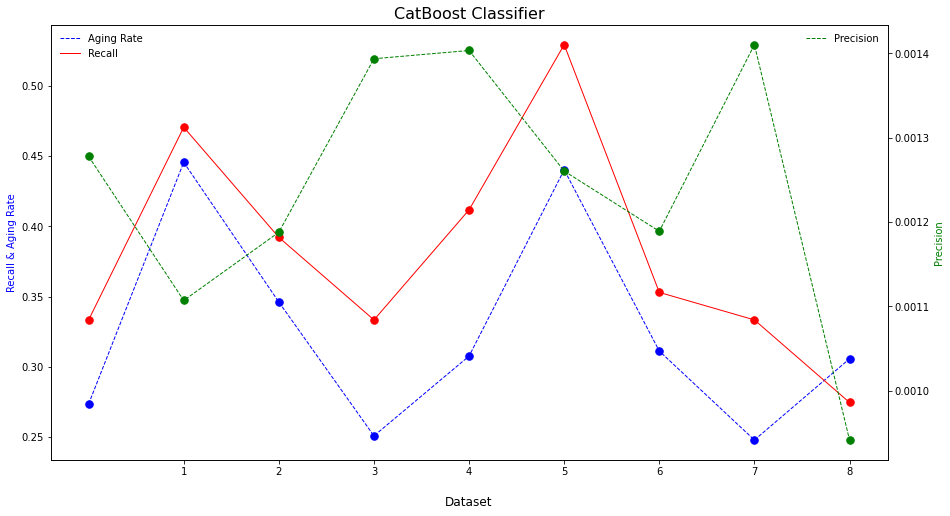

,Balance Ratio,Train_OK,Train_NG,TP,FP,FN,TN,Precision,Recall,Aging Rate,Efficiency,F1 Score,Score
dataset1,1.000000,3067.0,3067.0,17.0,13285.0,34.0,35313.0,0.001278,0.333333,0.273428,1.219090,0.001273,0.265699
dataset2,1.000000,2985.0,2985.0,24.0,21655.0,27.0,26943.0,0.001107,0.470588,0.445621,1.056029,0.001104,0.339189
dataset3,1.000000,3038.0,3038.0,20.0,16815.0,31.0,31783.0,0.001188,0.392157,0.346050,1.133237,0.001184,0.297114
dataset4,1.000000,3038.0,3038.0,17.0,12180.0,34.0,36418.0,0.001394,0.333333,0.250714,1.329535,0.001388,0.281889
dataset5,1.006623,3040.0,3020.0,21.0,14941.0,30.0,33657.0,0.001404,0.411765,0.307550,1.338855,0.001399,0.349861
dataset6,1.015364,3040.0,2994.0,27.0,21392.0,24.0,27206.0,0.001261,0.529412,0.440276,1.202454,0.001258,0.418009
dataset7,1.000000,3040.0,3040.0,18.0,15119.0,33.0,33479.0,0.001189,0.352941,0.311147,1.134322,0.001185,0.267582
dataset8,1.000000,3040.0,3040.0,17.0,12036.0,34.0,36562.0,0.001410,0.333333,0.247754,1.345419,0.001404,0.284155
dataset9,10.000000,3040.0,304.0,14.0,14855.0,37.0,33743.0,0.000942,0.274510,0.305638,0.898152,0.000938,0.000000


In [8]:
line_chart(table_setC, title = 'CatBoost Classifier')
table_setC

### Export

In [9]:
savedate = '20220405'
TPE_multi = False

table_setC['sampler'] = 'multivariate-TPE' if TPE_multi else 'univariate-TPE'
table_setC['model'] = 'CatBoost'
with pd.ExcelWriter(f'{savedate}_Classifier.xlsx', mode = 'a') as writer:
    table_setC.to_excel(writer, sheet_name = 'CatBoost')